# **Importing all necessary libraries**

In [ ]:
import warnings
warnings.simplefilter('ignore')
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2024-04-01 07:37:20.548810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 07:37:20.548905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 07:37:20.676827: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Univariate data**

## **Importing dataset**

In [ ]:
df=pd.read_csv('/kaggle/input/national-stock-exchange-time-series/tcs_stock.csv')
df=df[['Date','Close']]
df['Date']=pd.to_datetime(df['Date'])
display(df)

Date    Close
0   2015-01-01  2545.55
1   2015-01-02  2579.45
2   2015-01-05  2540.25
3   2015-01-06  2446.60
4   2015-01-07  2417.70
..         ...      ...
243 2015-12-24  2434.25
244 2015-12-28  2462.70
245 2015-12-29  2455.80
246 2015-12-30  2418.30
247 2015-12-31  2436.85

[248 rows x 2 columns]

## **Visualizing time series**

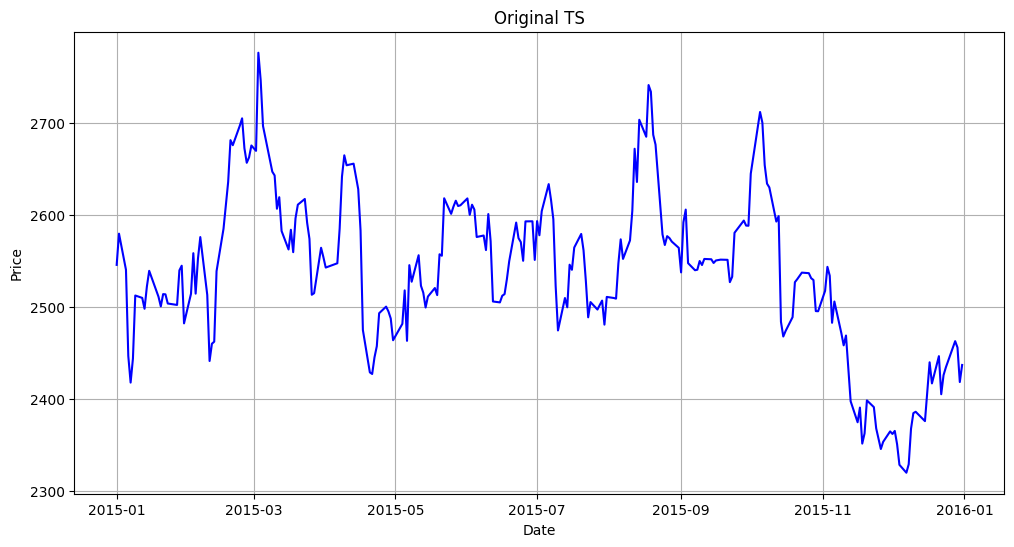

In [ ]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,1,1)
ax.set_title('Original TS')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.grid()
ax.plot(df.set_index('Date'),color='b')
plt.show()

## **Filling missed values**

In [ ]:
dates=[]
start=datetime.date(2015,1,1)
end=datetime.date(2015,12,31)
for i in range((end-start).days+1):
    dates.append(start+datetime.timedelta(days=i))
df_=pd.DataFrame(columns=['Date'],data=dates)
df_['Date']=pd.to_datetime(df_['Date'])
df=df.merge(df_,how='right',on='Date')
display(df)

Date    Close
0   2015-01-01  2545.55
1   2015-01-02  2579.45
2   2015-01-03      NaN
3   2015-01-04      NaN
4   2015-01-05  2540.25
..         ...      ...
360 2015-12-27      NaN
361 2015-12-28  2462.70
362 2015-12-29  2455.80
363 2015-12-30  2418.30
364 2015-12-31  2436.85

[365 rows x 2 columns]

In [ ]:
for i in range(df.shape[0]):
    if df.loc[i,'Close']!=df.loc[i,'Close']:
        df.loc[i,'Close']=df.loc[i-1,'Close']
df['Close']=df['Close']
display(df)

Date    Close
0   2015-01-01  2545.55
1   2015-01-02  2579.45
2   2015-01-03  2579.45
3   2015-01-04  2579.45
4   2015-01-05  2540.25
..         ...      ...
360 2015-12-27  2434.25
361 2015-12-28  2462.70
362 2015-12-29  2455.80
363 2015-12-30  2418.30
364 2015-12-31  2436.85

[365 rows x 2 columns]

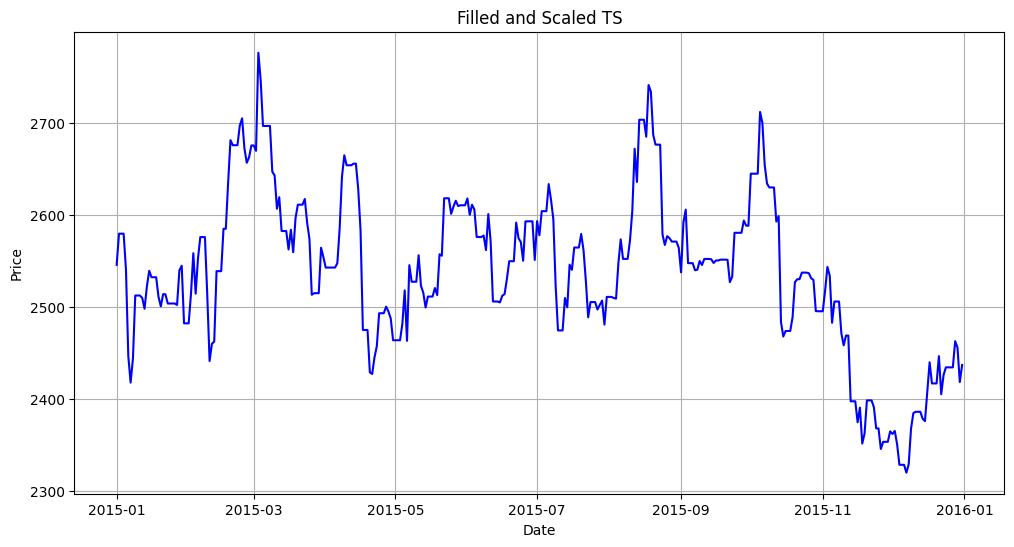

In [ ]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,1,1)
ax.set_title('Filled and Scaled TS')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.grid()
ax.plot(df.set_index('Date'),color='b')
plt.show()

## **Defining all global variables**

In [ ]:
n_features=1
n=df.shape[0]
train_ratio=0.75
n_train=int(train_ratio*n)
BATCH_SIZE=4
target_size=7
n_units=8
EPOCHS=25
es=tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=EPOCHS,restore_best_weights=True)

## **Saving values of time series into array**

In [ ]:
data=np.zeros(shape=(n,n_features))
data[:,0]=df['Close'].values
data[:7]

array([[2545.55],
       [2579.45],
       [2579.45],
       [2579.45],
       [2540.25],
       [2446.6 ],
       [2417.7 ]])

## **Splitting data on train and test**

In [ ]:
data_train,data_test=data[:n_train],data[n_train:]

## **Defining all necessary functions**

In [ ]:
def create_dataset(X,window_size,pred_size=target_size):
    t,n=X.shape
    X_slide=np.zeros((t-window_size-target_size+1,window_size+target_size,n))
    for i in range(X_slide.shape[0]):
        X_slide[i]=X[i:i+window_size+target_size]
    return X_slide[:,:window_size],X_slide[:,window_size:]

In [ ]:
def forecast(model,history,n_input):
    data=np.array(history)
    data=data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
    input_x=data[-n_input:,:]
    input_x=input_x.reshape((1,input_x.shape[0],input_x.shape[1]))
    yhat=model(input_x)
    yhat=yhat[0]
    return yhat

In [ ]:
def evaluate_forecasts(actual,predicted):
    predicted=predicted.reshape(actual.shape)
    scores=[]
    for i in range(actual.shape[1]):
        rmse=(np.mean((actual[:,i]-predicted[:,i])**2))**0.5
        scores.append(rmse)
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s+=(actual[row,col]-predicted[row,col])**2
    score=(s/(actual.shape[0]*actual.shape[1]))**0.5
    return score,scores

In [ ]:
def split_into_windows(data,sample):
    if sample=='train':
        return np.array(np.split(data[-(len(data)//target_size)*target_size:],(len(data)//target_size)))
    elif sample=='test':
        return np.array(np.split(data[:(len(data)//target_size)*target_size],(len(data)//target_size)))

In [ ]:
def evaluate_model(model,train,test,n_input):
    history=[x for x in split_into_windows(train,'train')]
    test=split_into_windows(test,'test')
    predictions=[]
    for i in range(len(test)):
        yhat_sequence=forecast(model,history,n_input)
        predictions.append(yhat_sequence)
        history.append(test[i,:])
    predictions=np.array(predictions)
    score,scores=evaluate_forecasts(test,predictions)
    fig=plt.figure(figsize=(12,6*target_size))
    for i in range(target_size):
        ax=fig.add_subplot(target_size,1,i+1)
        ax.set_title(f'Day {i+1}')
        ax.plot(test[:,i],color='c',label='real',marker='o')
        ax.plot(predictions[:,i],color='m',label='predicted',marker='o')
        ax.grid()
        ax.legend()
    plt.show()
    return score,scores

In [ ]:
def plot_error_days(scores):
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_ylabel('RMSE')
    ax.set_xlabel('Day')
    ax.grid()
    ax.plot([i for i in range(1,target_size+1)],scores,marker='o')
    plt.show()

In [ ]:
def base_model(layer,wind_size,a=0.1):
    model=tf.keras.Sequential([layer(units=n_units,activation=tf.keras.layers.LeakyReLU(a),return_sequences=True,input_shape=(wind_size,n_features)),
                               layer(units=n_units,activation=tf.keras.layers.LeakyReLU(a),return_sequences=False),
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(units=target_size,activation='linear')])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='mse')
    return model

In [ ]:
def delayed_model(layer,wind_size,a=0.1):
    model=tf.keras.Sequential([layer(units=n_units,activation=tf.keras.layers.LeakyReLU(a),return_sequences=False,input_shape=(wind_size,n_features)),
                               tf.keras.layers.RepeatVector(target_size),
                               layer(units=n_units,activation=tf.keras.layers.LeakyReLU(a),return_sequences=True),
                               tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=n_units,activation=tf.keras.layers.LeakyReLU(a))),
                               tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=n_features))])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='mse')
    return model

## **Simple models**

### **LSTM**

#### **7 days**

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 8)           │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 927 (3.62 KB)

 Trainable params: 927 (3.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
56/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6588984.5000

I0000 00:00:1711957056.621425      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6587714.5000
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6554354.5000
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6545664.5000
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6416534.0000
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5849755.5000
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3051745.7500
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 292834.5000
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118051.1016
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52262.5273
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18572.6934
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7909.1377
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5604.7158
Epoch 13/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5919.8486
Epoch 14/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5812.4395
Epoch 15/25
65/65 ━━━━━━━━━━━━

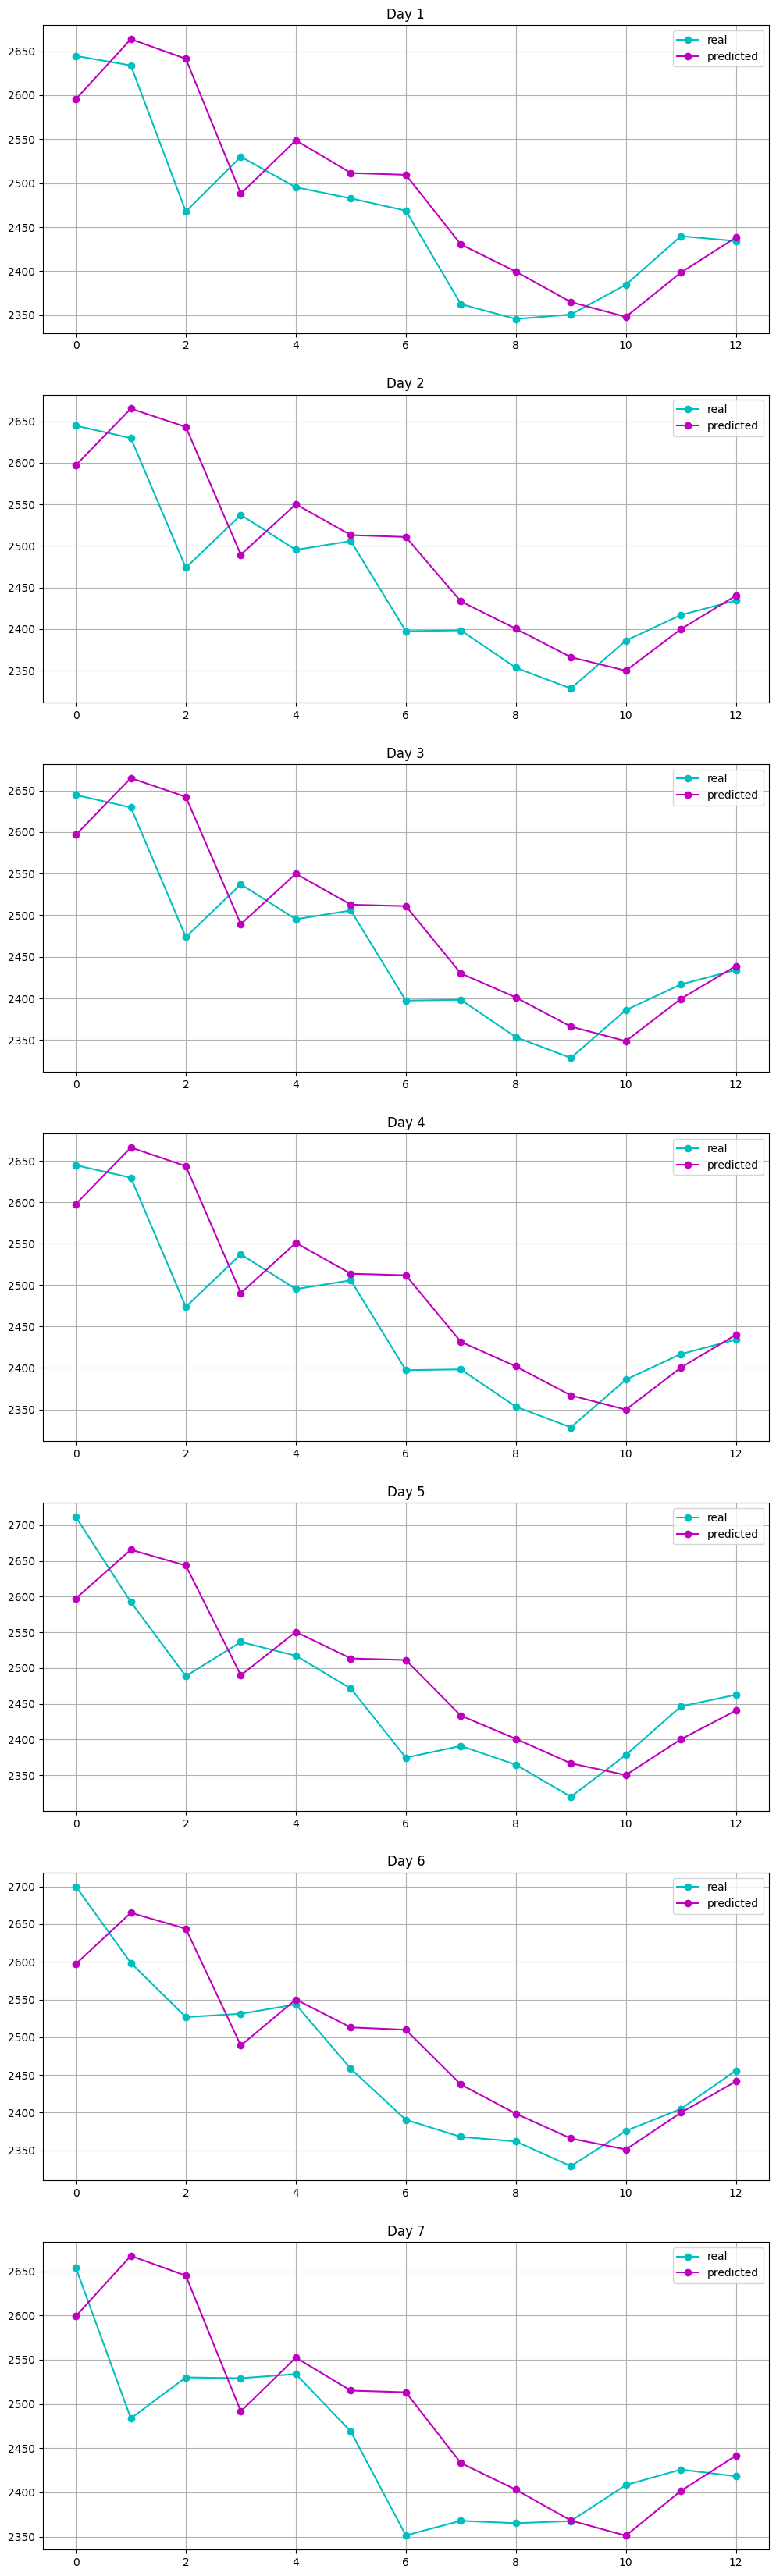

[69.78888905] 
 [62.821314679021576, 66.12925843820302, 66.0011833824745, 66.43477277895148, 75.862472674612, 65.71321296009143, 83.25112903436523]


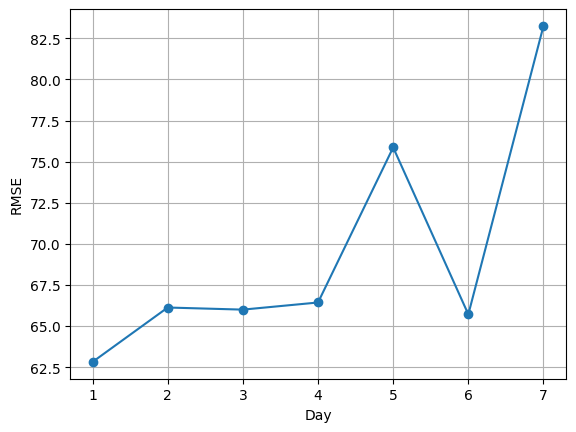

In [ ]:
n_input=7
model=base_model(tf.keras.layers.LSTM,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es])
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score,'\n',scores)
plot_error_days(scores)

#### **14 days**

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 14, 8)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 927 (3.62 KB)

 Trainable params: 927 (3.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6576289.0000
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5995040.0000
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3677440.5000
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1886376.5000
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1154471.2500
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 626367.6250
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 366240.7812
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 189895.7188
Epoch 9/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 84979.4375
Epoch 10/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34543.6992
Epoch 11/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12348.9629
Epoch 12/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7363.4590
Epoch 13/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5943.6104
Epoch 14/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5564.9688
Epoch 15/25
64/64 

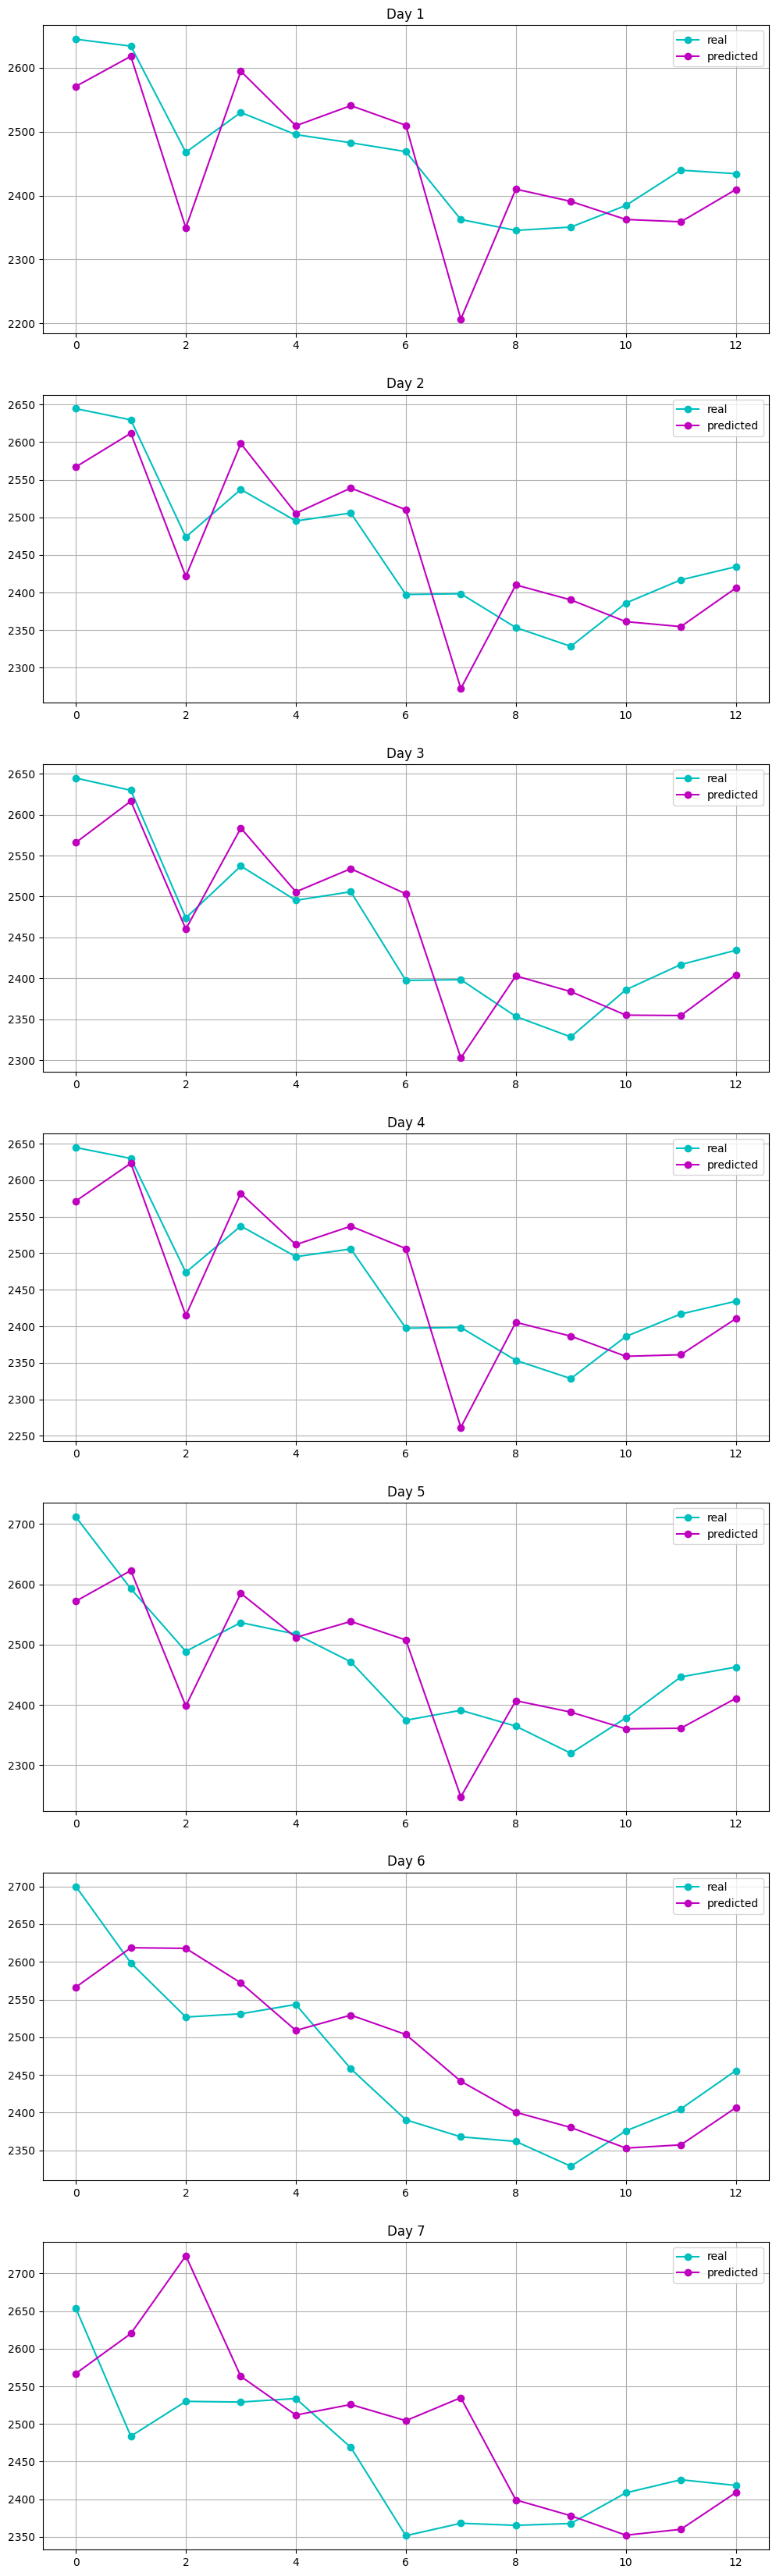

[73.90212485] 
 [71.6259474321507, 64.9770761796325, 56.30033198696035, 63.94777328476441, 83.40432914157194, 69.07510152329965, 99.45689901694455]


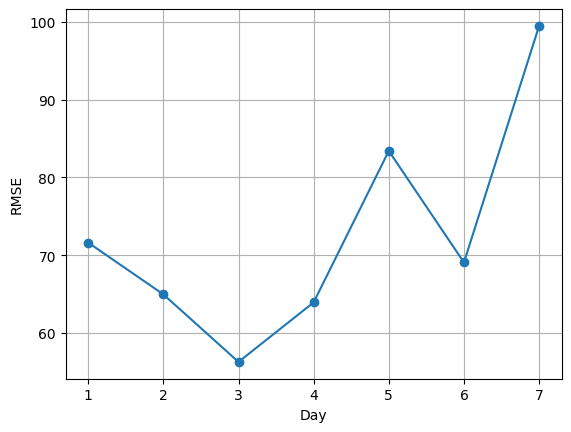

In [ ]:
n_input=14
model=base_model(tf.keras.layers.LSTM,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es])
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score,'\n',scores)
plot_error_days(scores)

### **GRU**

#### **7 days**

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7, 8)           │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 8)              │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 759 (2.96 KB)

 Trainable params: 759 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6639349.5000
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6518892.5000
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6026455.5000
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4768914.5000
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2782582.7500
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 660294.6250
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80388.8125
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14221.2070
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5958.5806
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4789.8638
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4923.0747
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4626.2993
Epoch 13/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4827.6523
Epoch 14/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4781.4512
Epoch 15/25
65/65 ━━━━━━

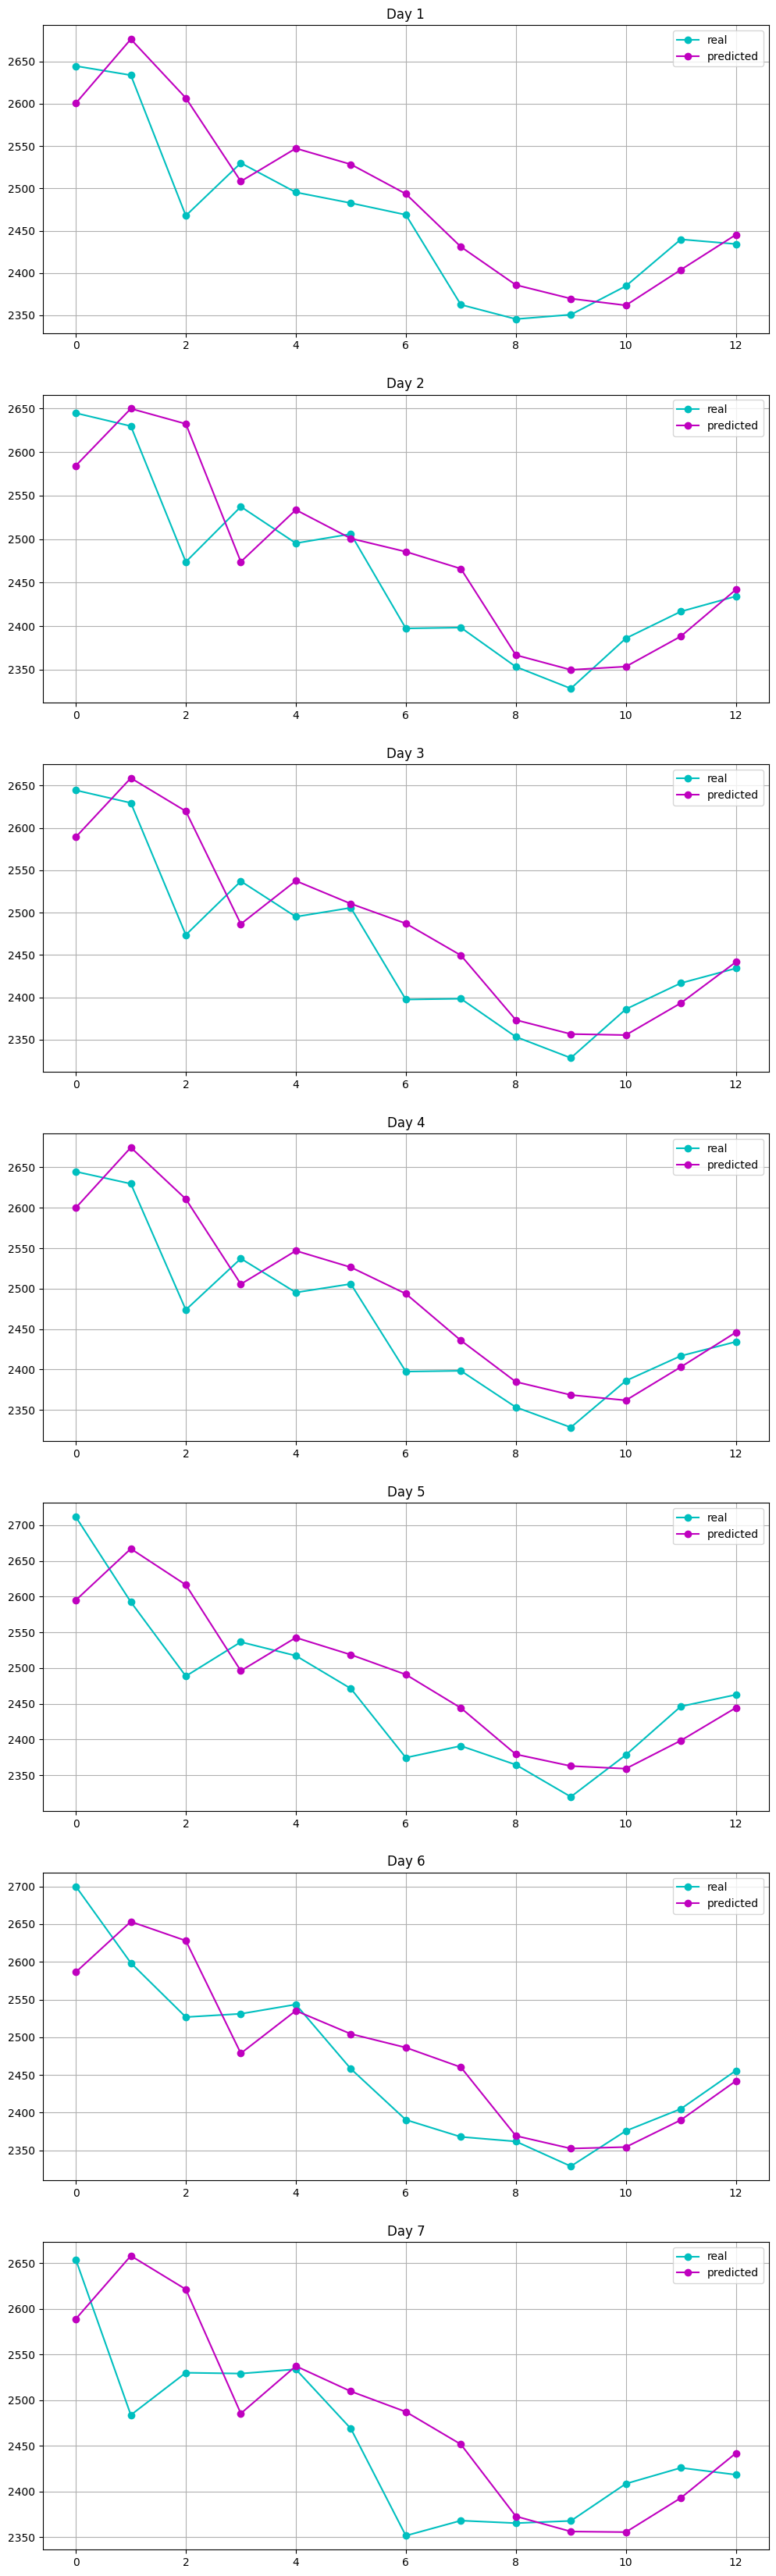

[62.86001783] 
 [53.7468426996438, 61.73675459006965, 57.5532955541911, 56.175950687801766, 68.73637330137191, 62.206973568606315, 76.79197280550284]


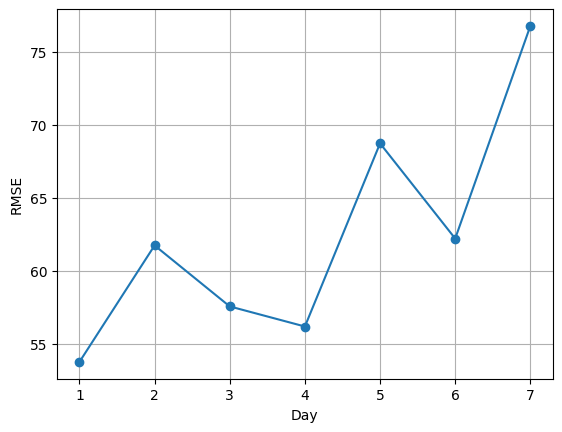

In [ ]:
n_input=7
model=base_model(tf.keras.layers.GRU,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es])
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score,'\n',scores)
plot_error_days(scores)

#### **14 days**

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 14, 8)          │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 8)              │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 759 (2.96 KB)

 Trainable params: 759 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 5859546.0000
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3299596.7500
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1315668.8750
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 393410.5625
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45493.6562
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5354.6060
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4164.0723
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4703.9058
Epoch 9/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4930.4634
Epoch 10/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5927.2114
Epoch 11/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5420.1606
Epoch 12/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10175.7197
Epoch 13/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8587.3965
Epoch 14/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4398.1885
Epoch 15/25
64/64 ━━━━━━━━━━━

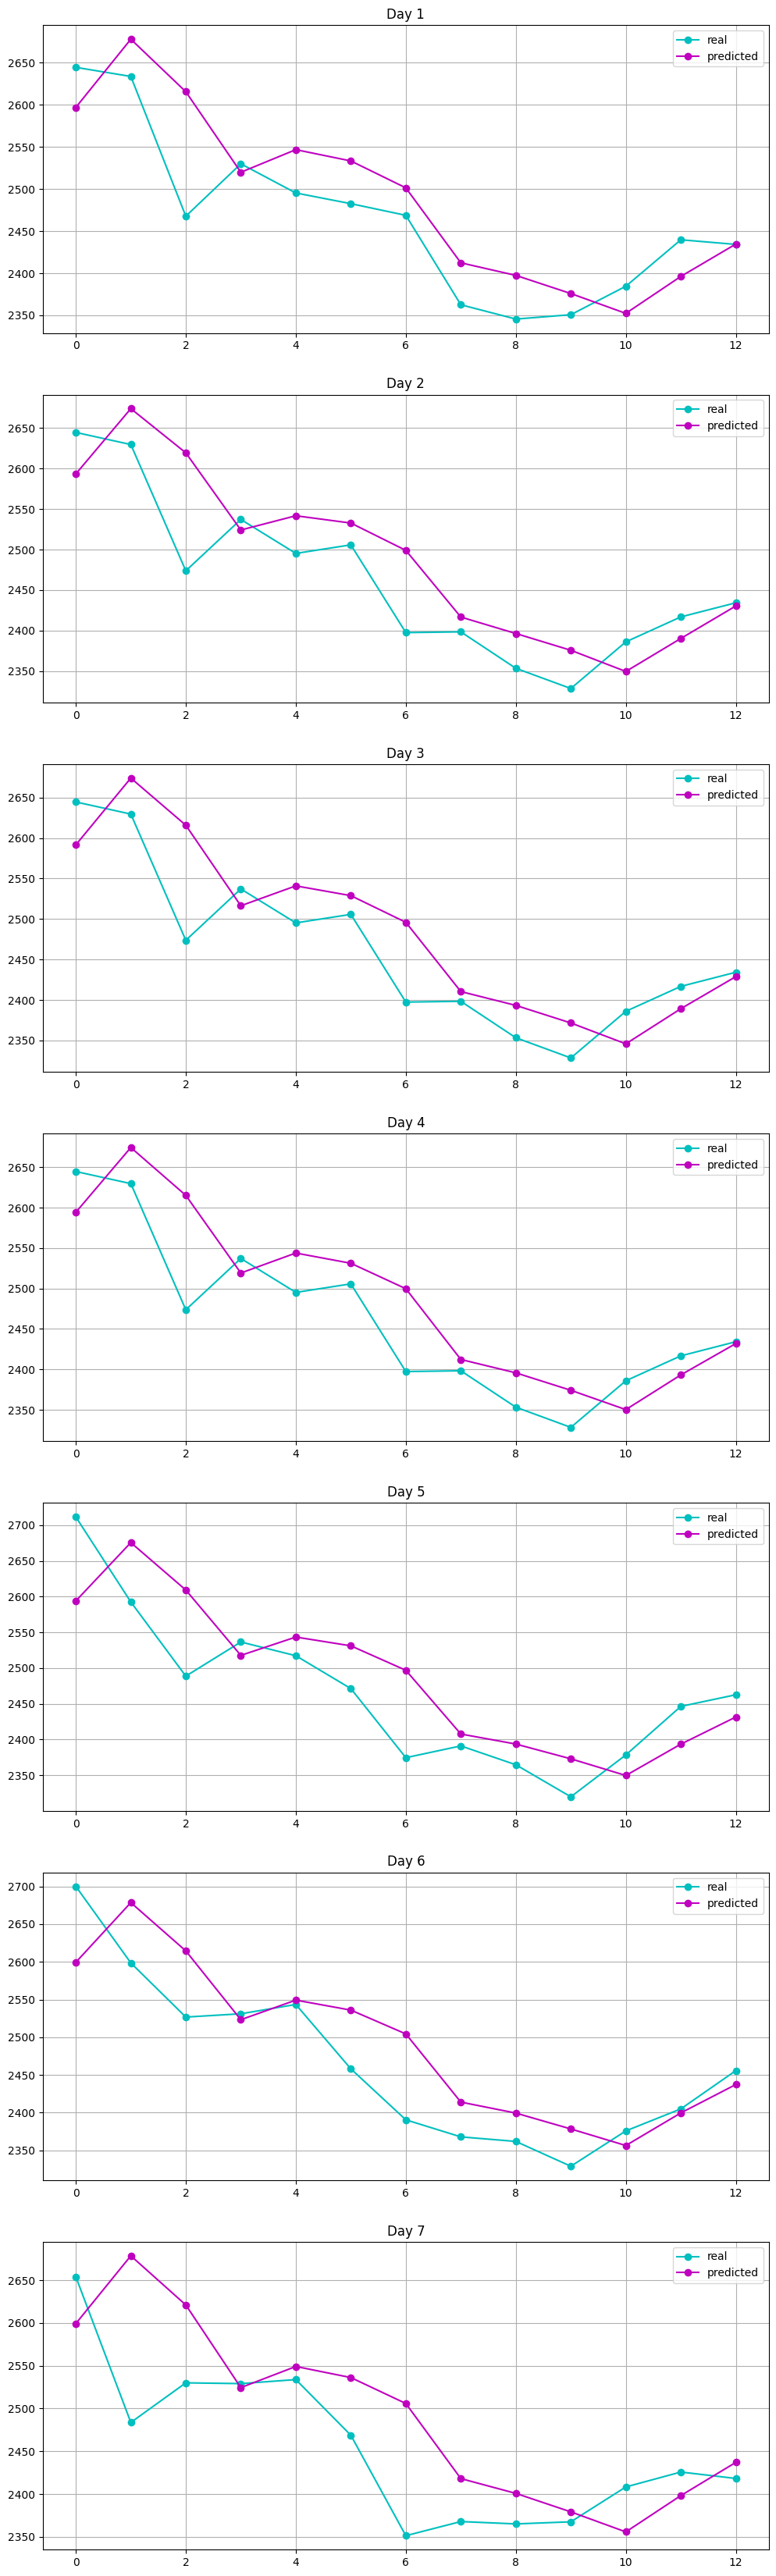

[64.10949391] 
 [56.31906389420868, 59.25514612834881, 58.02083333443262, 58.34915866721593, 69.84580684708102, 62.059474320507206, 81.15617447873393]


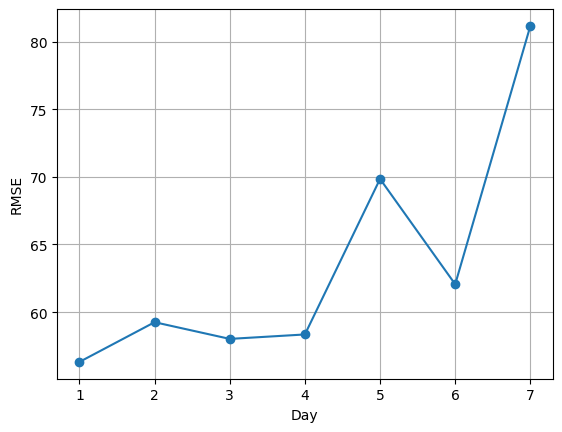

In [ ]:
n_input=14
model=base_model(tf.keras.layers.GRU,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es])
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score,'\n',scores)
plot_error_days(scores)

## **Delayed models**

### **LSTM**

#### **7 days**

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 7, 8)           │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 8)           │            72 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 7, 1)           │             9 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 945 (3.69 KB)

 Trainable params: 945 (3.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6146577.0000
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1267372.3750
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 588958.5000
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 519640.5312
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 452246.2188
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 379677.0938
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 303685.4062
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 232927.2969
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 151661.7344
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 126373.6875
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49979.6484
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32852.3203
Epoch 13/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22027.3242
Epoch 14/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15116.5391
Epoch 15/25
65/65

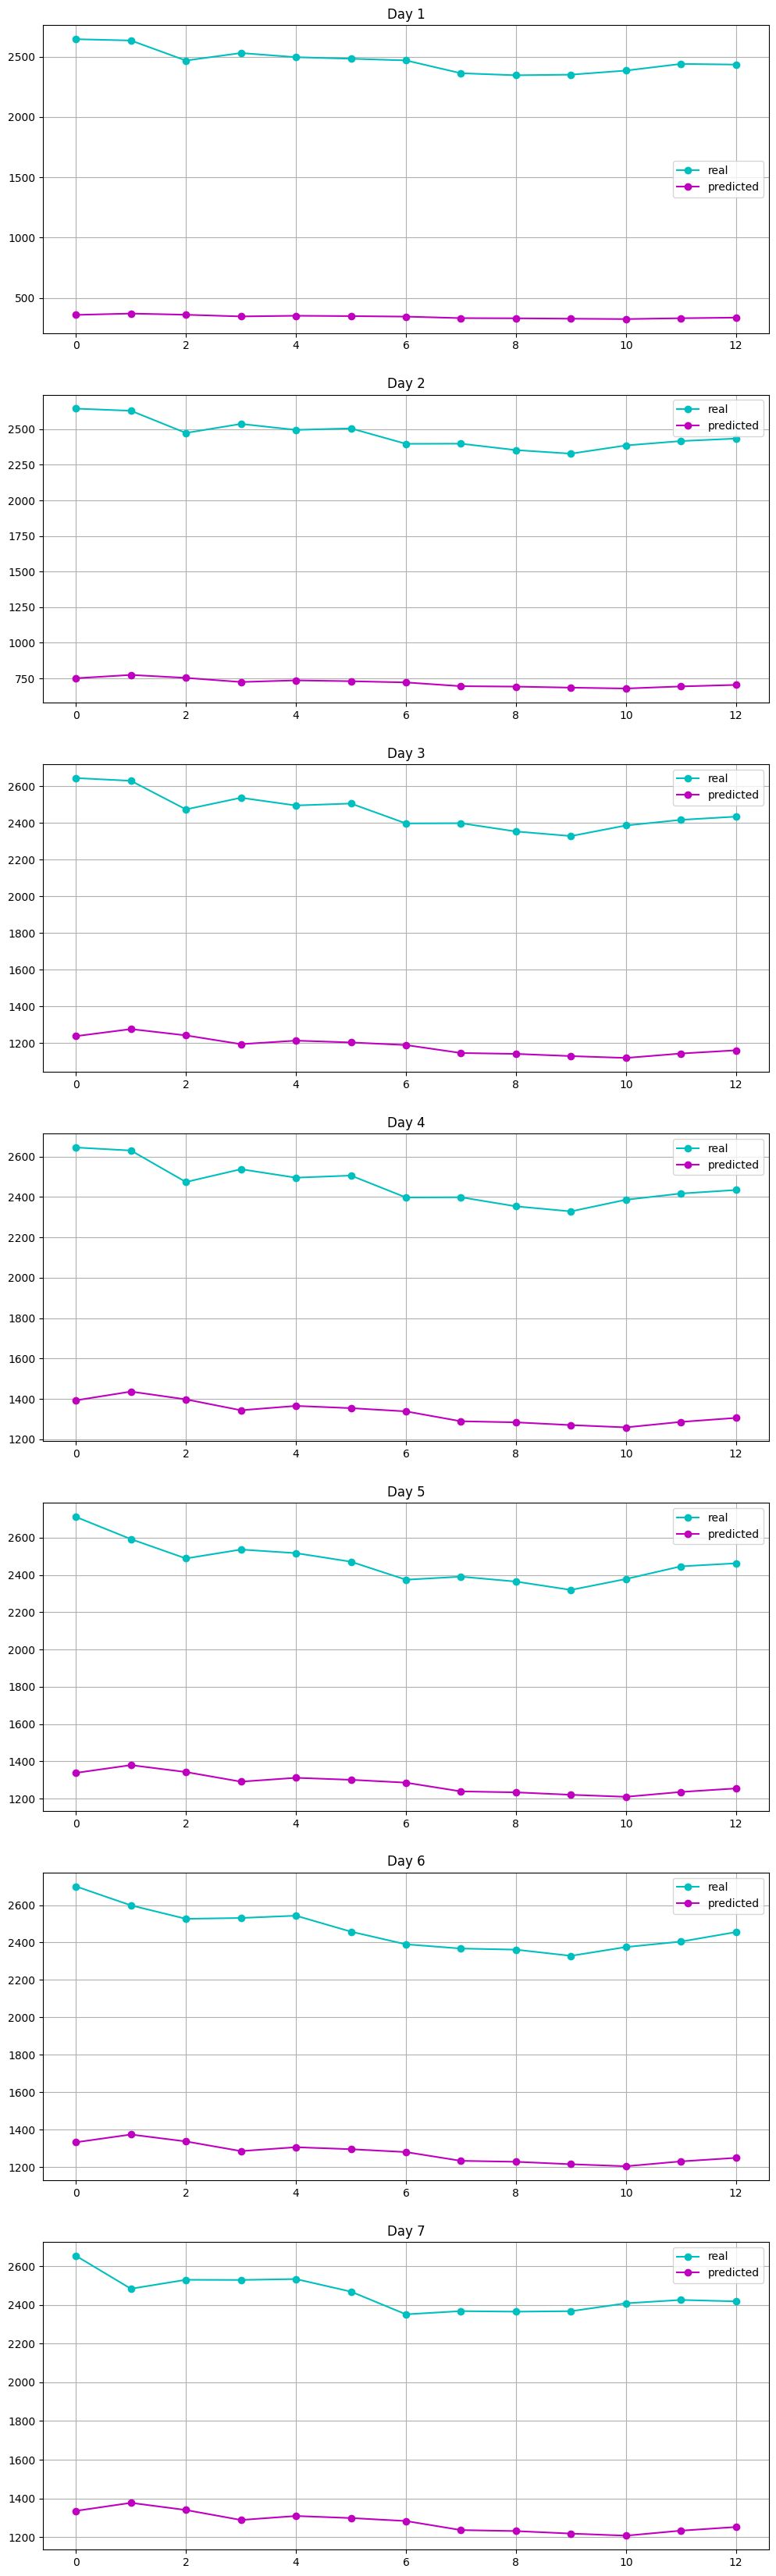

[1448.2454634] 
 [2122.0145288715103, 1744.949048598421, 1279.3137612853382, 1130.131203872005, 1188.1765919287145, 1191.57557802584, 1178.4122383047077]


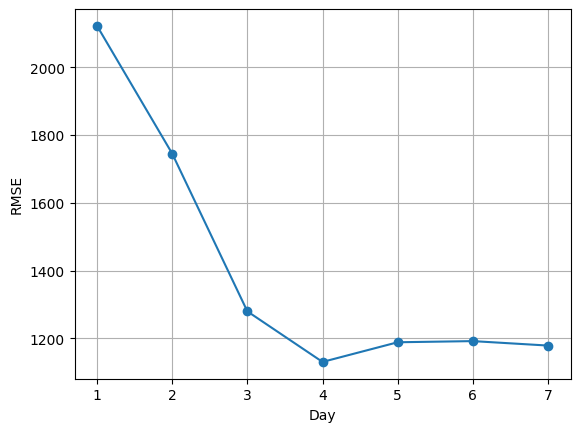

In [ ]:
n_input=7
model=delayed_model(tf.keras.layers.LSTM,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es])
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score,'\n',scores)
plot_error_days(scores)

#### **14 days**

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 7, 8)           │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 7, 8)           │            72 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 7, 1)           │             9 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 945 (3.69 KB)

 Trainable params: 945 (3.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 6715282.5000
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 963207.5625
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 790035.0625
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 704320.3750
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 674422.0000
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 651297.8750
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 620205.4375
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 593213.5000
Epoch 9/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 563451.8750
Epoch 10/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 526006.5000
Epoch 11/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 480223.7812
Epoch 12/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 431252.5938
Epoch 13/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 364653.9062
Epoch 14/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 294144.1562
Epoch 15/25
6

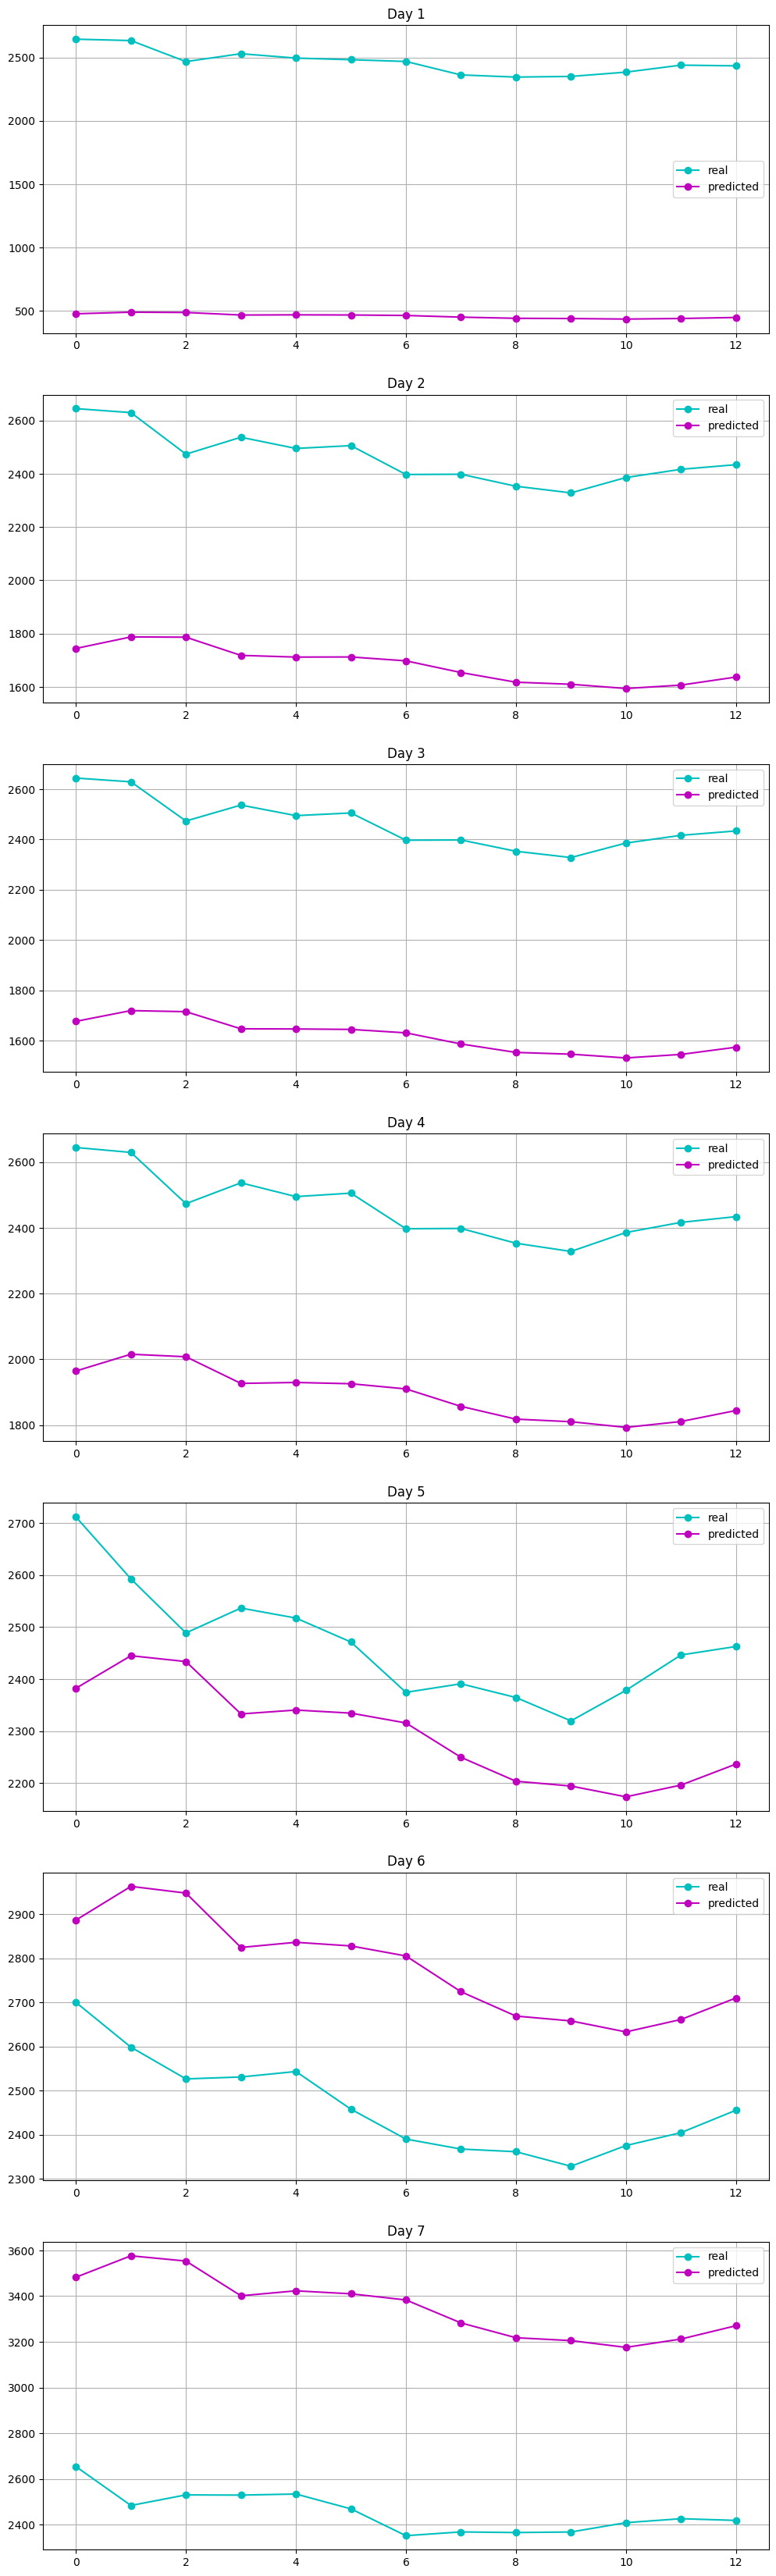

[973.54079256] 
 [2006.4898405247195, 780.6298791609184, 846.9551653788973, 570.8404634351201, 184.98612596598898, 322.27267942770897, 904.3316877821746]


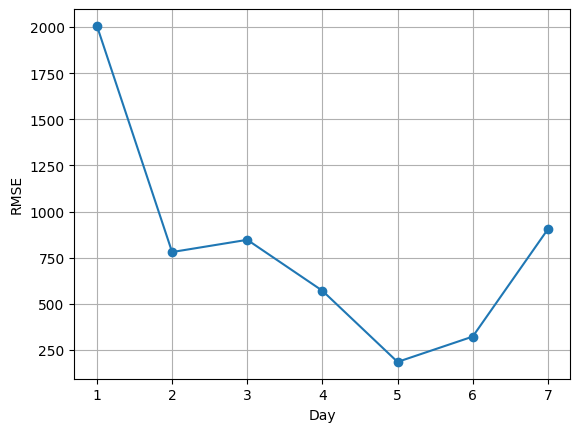

In [ ]:
n_input=14
model=delayed_model(tf.keras.layers.LSTM,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es])
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score,'\n',scores)
plot_error_days(scores)

### **GRU**

#### **7 days**

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 7, 8)           │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 7, 8)           │            72 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 7, 1)           │             9 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777 (3.04 KB)

 Trainable params: 777 (3.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6579789.5000
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6325849.5000
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5038192.5000
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1536078.5000
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32342.0508
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19063.1191
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12255.4541
Epoch 8/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8189.1714
Epoch 9/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6065.5371
Epoch 10/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5292.4473
Epoch 11/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4229.8442
Epoch 12/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4120.1606
Epoch 13/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3935.7073
Epoch 14/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3822.4607
Epoch 15/25
65/65 ━━━━━━━━━━

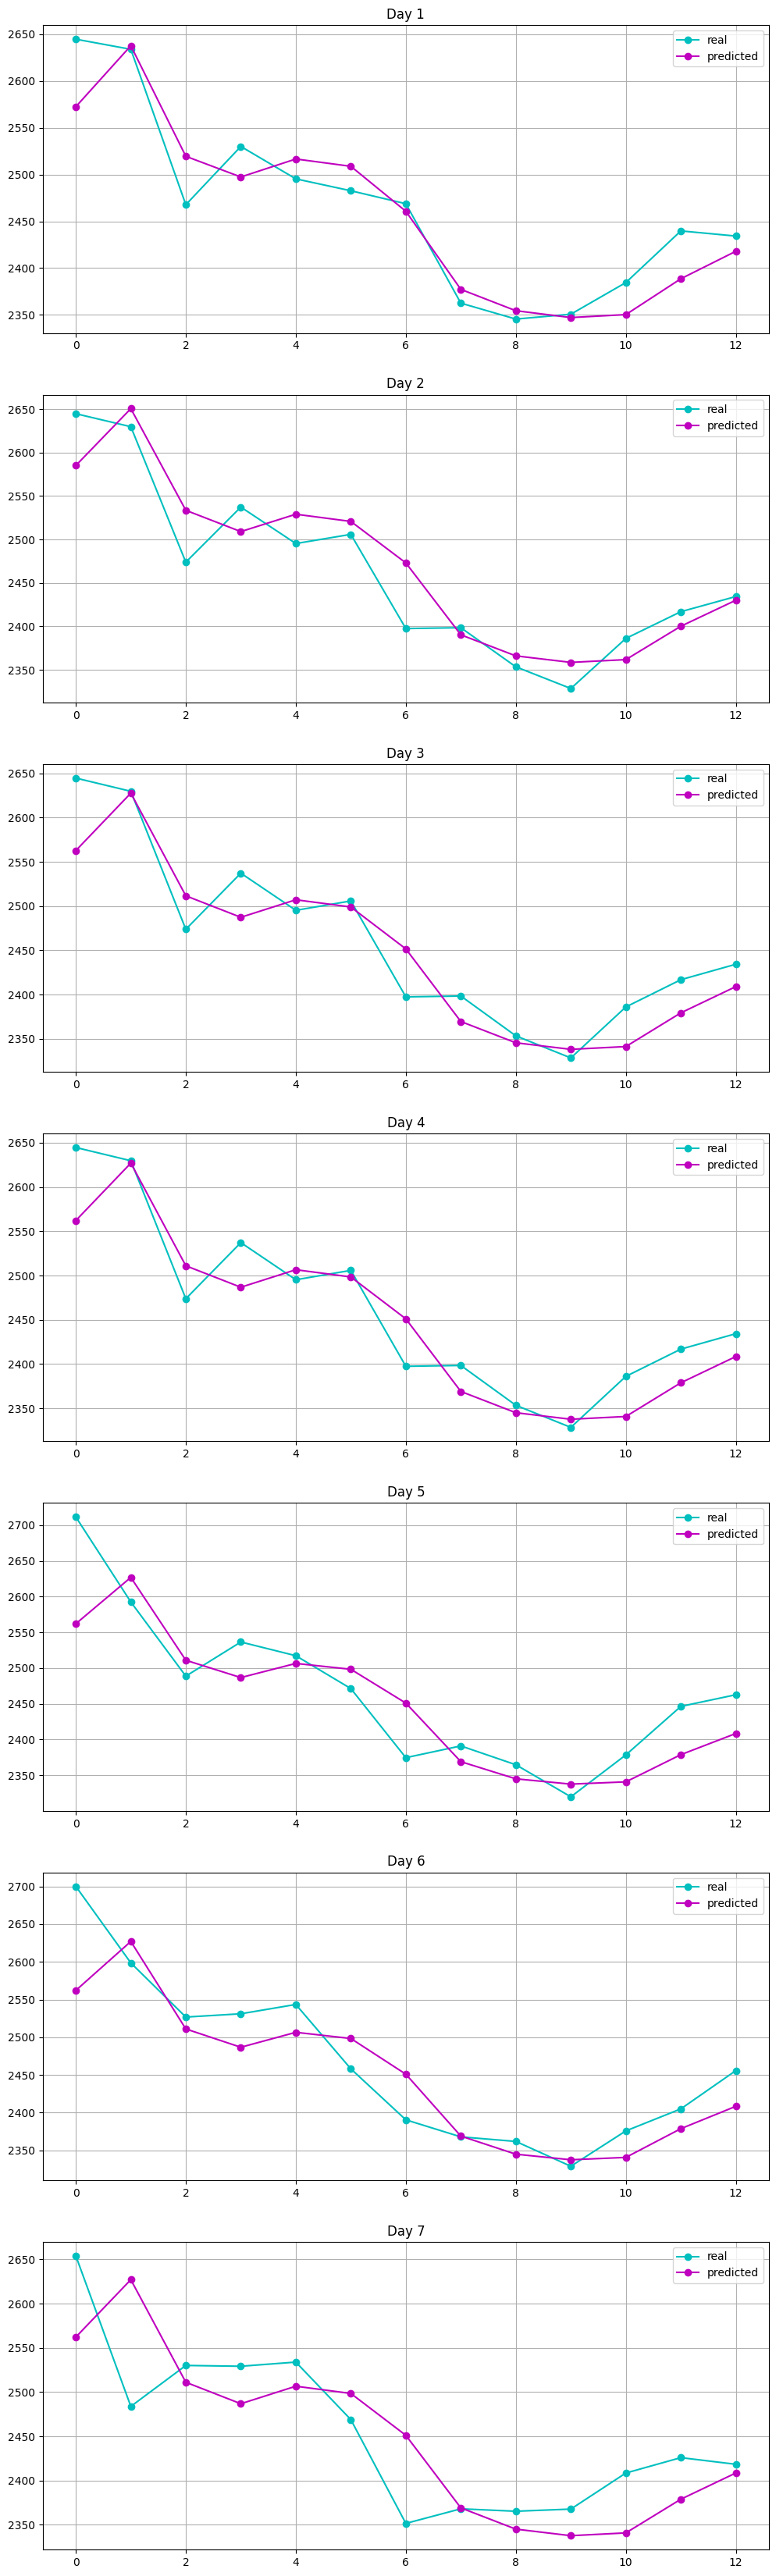

[46.54408478] 
 [33.42100910549014, 36.62032601769373, 38.015812704315245, 38.21491297177781, 57.7405216346803, 50.543518359676526, 62.54801347896158]


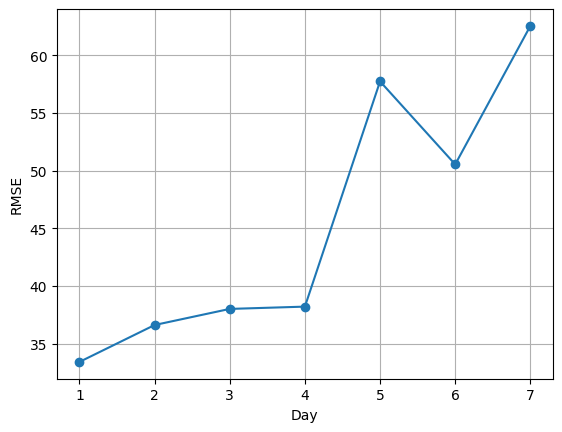

In [ ]:
n_input=7
model=delayed_model(tf.keras.layers.GRU,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es])
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score,'\n',scores)
plot_error_days(scores)

#### **14 days**

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 7, 8)           │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 7, 8)           │            72 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 7, 1)           │             9 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777 (3.04 KB)

 Trainable params: 777 (3.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 5946491.5000
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4067693.7500
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 504910.5000
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4189.2344
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3916.0020
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3978.3840
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4186.9023
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4359.1958
Epoch 9/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4506.1147
Epoch 10/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4382.7290
Epoch 11/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4403.5640
Epoch 12/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4450.2339
Epoch 13/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4603.5562
Epoch 14/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4182.6880
Epoch 15/25
64/64 ━━━━━━━━━━━━━━━━

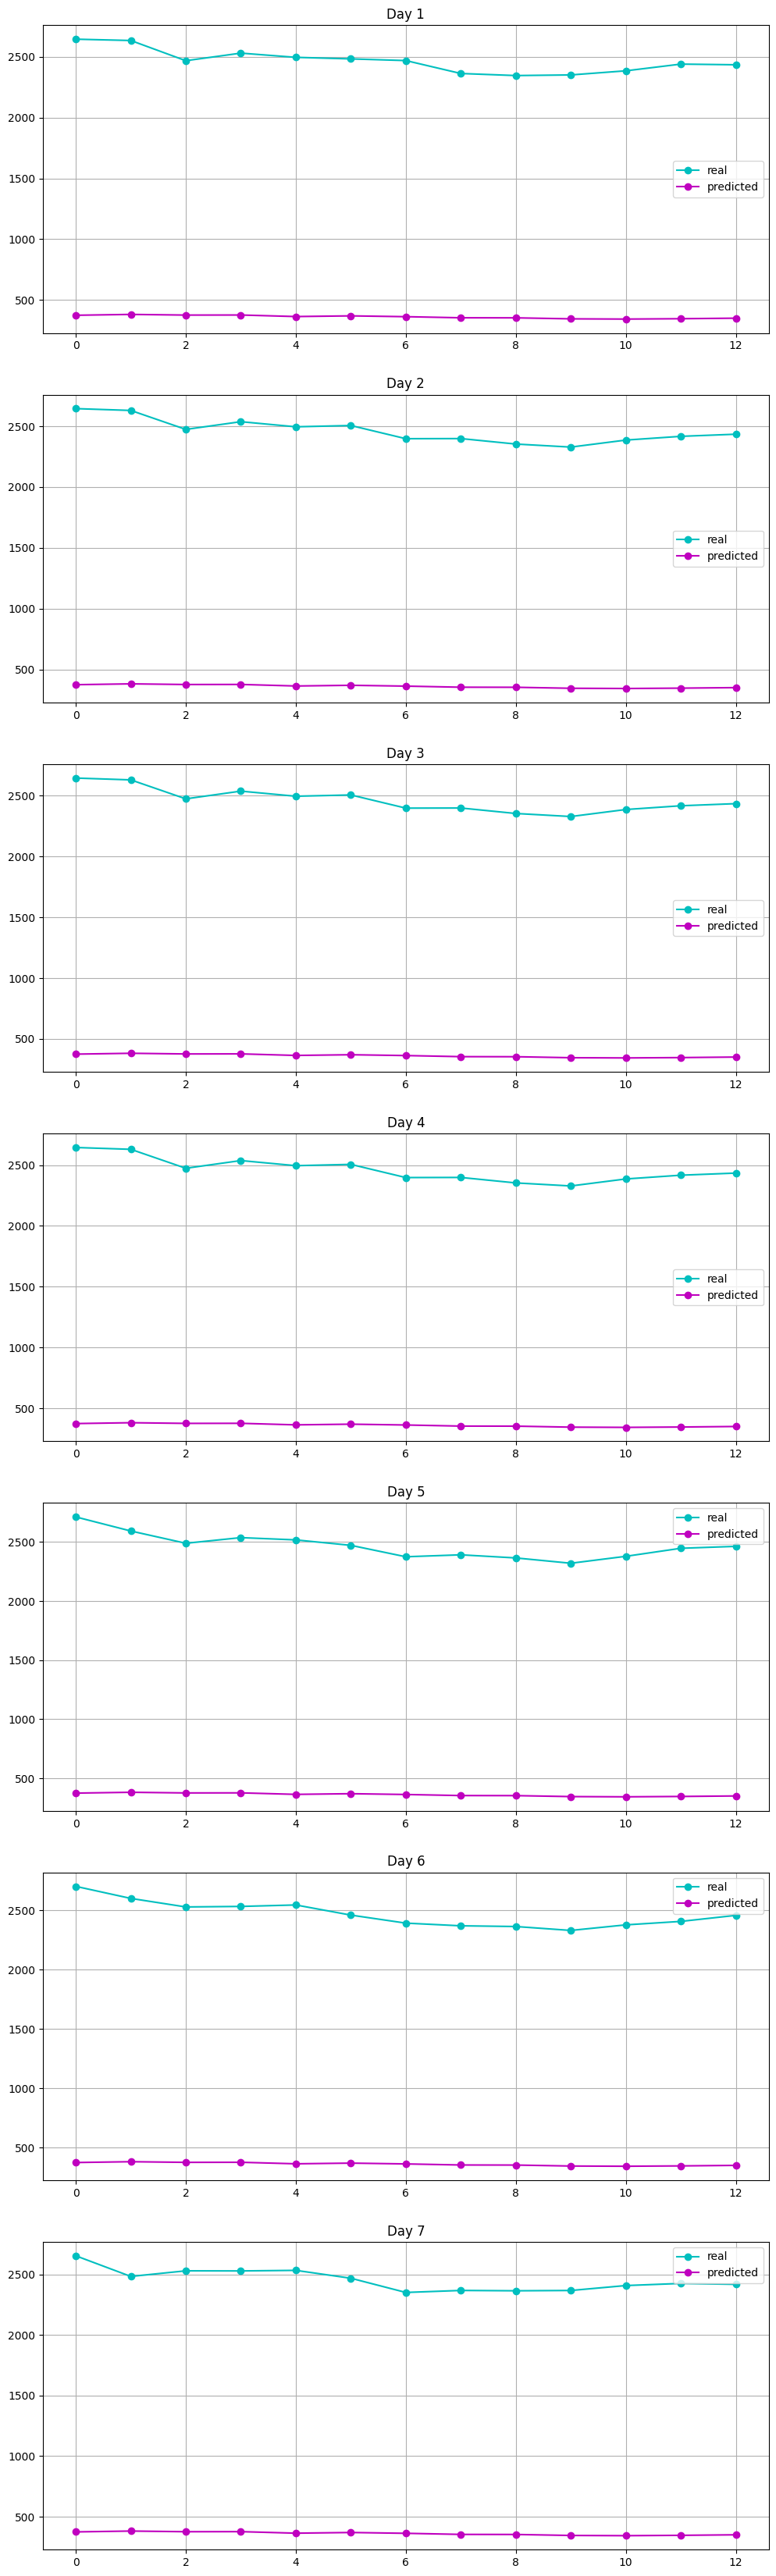

[2102.4743751] 
 [2104.919874490693, 2101.933470611208, 2101.933470611208, 2101.933470611208, 2106.5917657599916, 2105.7271777714677, 2094.257159049151]


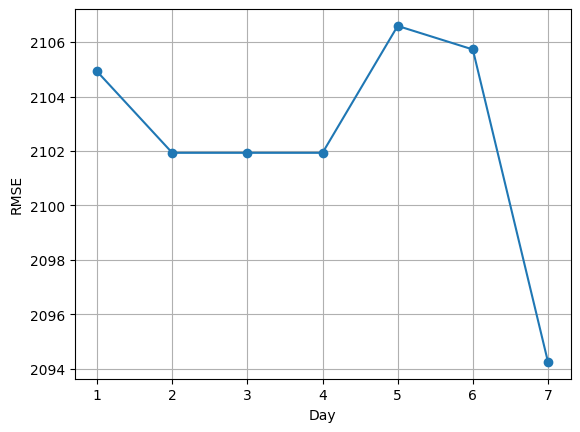

In [ ]:
n_input=14
model=delayed_model(tf.keras.layers.GRU,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es])
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score,'\n',scores)
plot_error_days(scores)

# **Multivariate data**

## **Preparing data**

In [ ]:
df1=pd.read_csv('/kaggle/input/national-stock-exchange-time-series/tcs_stock.csv')
df2=pd.read_csv('/kaggle/input/national-stock-exchange-time-series/nifty_it_index.csv')
df=pd.DataFrame(columns=['Date'],data=df1['Date'])
df['TCS']=df1['Close']
df['Nifty']=df2['Close']
df['Date']=pd.to_datetime(df['Date'])
display(df)

Date      TCS     Nifty
0   2015-01-01  2545.55  11215.70
1   2015-01-02  2579.45  11372.10
2   2015-01-05  2540.25  11248.55
3   2015-01-06  2446.60  10959.90
4   2015-01-07  2417.70  10916.00
..         ...      ...       ...
243 2015-12-24  2434.25  11184.90
244 2015-12-28  2462.70  11271.80
245 2015-12-29  2455.80  11253.45
246 2015-12-30  2418.30  11117.60
247 2015-12-31  2436.85  11212.55

[248 rows x 3 columns]

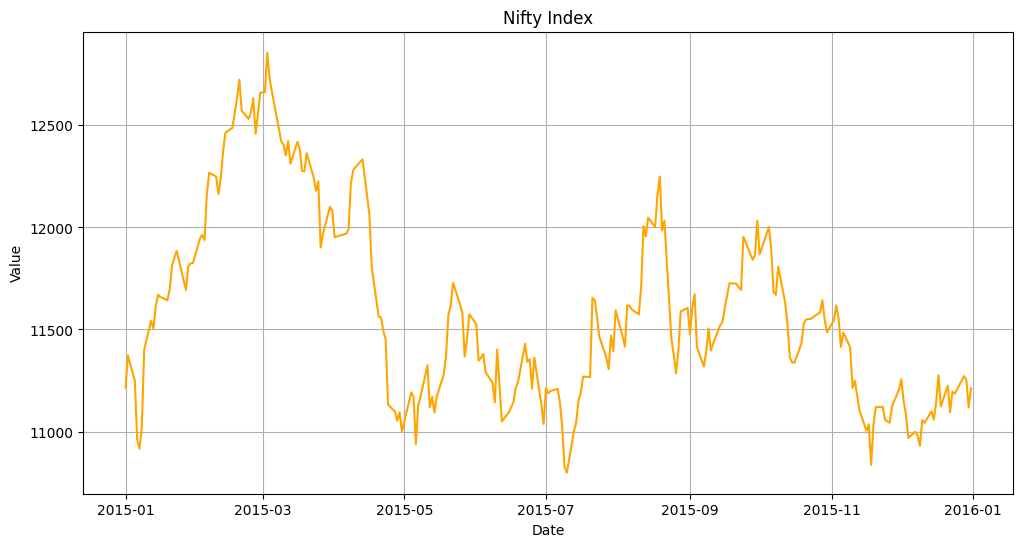

In [ ]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,1,1)
ax.set_title('Nifty Index')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.grid()
ax.plot(df['Date'],df['Nifty'],color='orange')
plt.show()

In [ ]:
dates=[]
start=datetime.date(2015,1,1)
end=datetime.date(2015,12,31)
for i in range((end-start).days+1):
    dates.append(start+datetime.timedelta(days=i))
df_=pd.DataFrame(columns=['Date'],data=dates)
df_['Date']=pd.to_datetime(df_['Date'])
df=df.merge(df_,how='right',on='Date')
display(df)

Date      TCS     Nifty
0   2015-01-01  2545.55  11215.70
1   2015-01-02  2579.45  11372.10
2   2015-01-03      NaN       NaN
3   2015-01-04      NaN       NaN
4   2015-01-05  2540.25  11248.55
..         ...      ...       ...
360 2015-12-27      NaN       NaN
361 2015-12-28  2462.70  11271.80
362 2015-12-29  2455.80  11253.45
363 2015-12-30  2418.30  11117.60
364 2015-12-31  2436.85  11212.55

[365 rows x 3 columns]

In [ ]:
for i in range(df.shape[0]):
    if df.loc[i,'TCS']!=df.loc[i,'TCS']:
        df.loc[i,'TCS']=df.loc[i-1,'TCS']
for i in range(df.shape[0]):
    if df.loc[i,'Nifty']!=df.loc[i,'Nifty']:
        df.loc[i,'Nifty']=df.loc[i-1,'Nifty']
display(df)

Date      TCS     Nifty
0   2015-01-01  2545.55  11215.70
1   2015-01-02  2579.45  11372.10
2   2015-01-03  2579.45  11372.10
3   2015-01-04  2579.45  11372.10
4   2015-01-05  2540.25  11248.55
..         ...      ...       ...
360 2015-12-27  2434.25  11184.90
361 2015-12-28  2462.70  11271.80
362 2015-12-29  2455.80  11253.45
363 2015-12-30  2418.30  11117.60
364 2015-12-31  2436.85  11212.55

[365 rows x 3 columns]

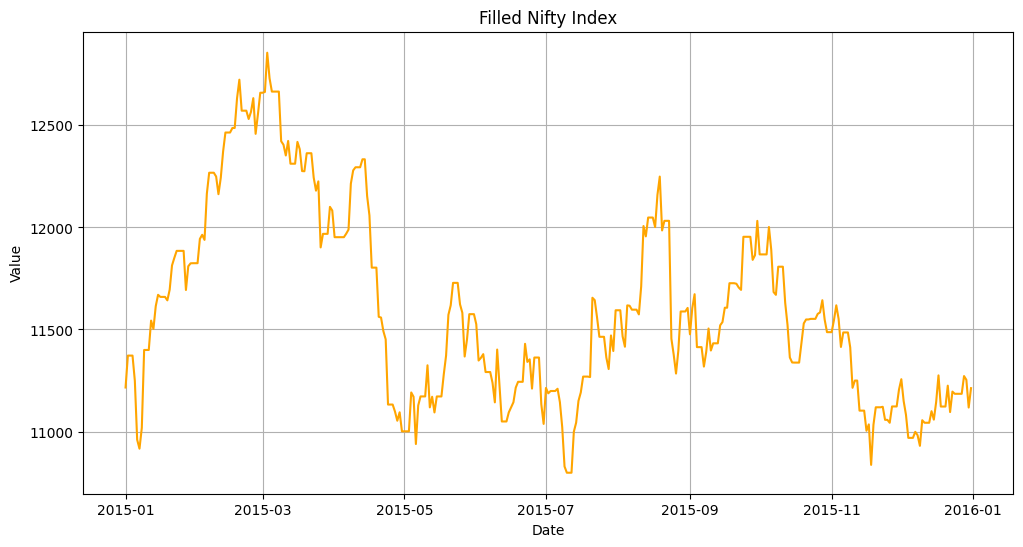

In [ ]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,1,1)
ax.set_title('Filled Nifty Index')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.grid()
ax.plot(df['Date'],df['Nifty'],color='orange')
plt.show()

## **Defining global variables**

In [ ]:
n_features=2
n=df.shape[0]
train_ratio=0.75
n_train=int(train_ratio*n)
BATCH_SIZE=4
target_size=7
n_units=8
EPOCHS=50
es=tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',patience=EPOCHS,restore_best_weights=True)

## **Redefining some necessary functions**

In [ ]:
def evaluate_forecasts(actual,predicted):
    scores_all=[]
    score_all=[]
    for j in range(actual.shape[2]):
        scores=[]
        for i in range(actual.shape[1]):
            rmse=((actual[:,i,j]-predicted[:,i,j])**2).mean()**0.5
            scores.append(rmse)
        s=0
        for row in range(actual.shape[0]):
            for col in range(actual.shape[1]):
                s+=(actual[row,col,j]-predicted[row,col,j])**2
        score=(s/(actual.shape[0]*actual.shape[1]))**0.5
        score_all.append(score)
        scores_all.append(scores)
    return score_all,scores_all

In [ ]:
def plot_error_days(scores):
    fig=plt.figure()
    ax=fig.add_subplot()
    ax.set_ylabel('RMSE')
    ax.set_xlabel('Day')
    ax.grid()
    ax.plot([i for i in range(1,target_size+1)],scores[0],marker='o')
    plt.show()

In [ ]:
def evaluate_model(model,train,test,n_input):
    history=[x for x in split_into_windows(train,'train')]
    test=split_into_windows(test,'test')
    predictions=[]
    for i in range(len(test)):
        yhat_sequence=forecast(model,history,n_input)
        predictions.append(yhat_sequence)
        history.append(test[i,:])
    predictions=np.array(predictions)
    score,scores=evaluate_forecasts(test,predictions)
    fig=plt.figure(figsize=(12,6*target_size))
    for i in range(target_size):
        ax=fig.add_subplot(target_size,1,i+1)
        ax.set_title(f'Day {i+1}')
        ax.plot(test[:,i,0],color='c',label='real',marker='o')
        ax.plot(predictions[:,i,0],color='m',label='predicted',marker='o')
        ax.grid()
        ax.legend()
    plt.show()
    return score,scores

## **Saving data into array and splitting it**

In [ ]:
data=np.zeros(shape=(n,n_features))
data[:,0]=df['TCS'].values
data[:,1]=df['Nifty'].values

In [ ]:
data_train,data_test=data[:n_train],data[n_train:]

## **Models**

### **LSTM**

#### **7 days**

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 8)              │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 7, 8)           │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 7, 8)           │            72 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 7, 2)           │            18 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 986 (3.85 KB)

 Trainable params: 986 (3.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 71792552.0000
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71539704.0000
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 69335376.0000
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47844772.0000
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44566040.0000
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42410892.0000
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39870064.0000
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36847100.0000
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32544538.0000
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26429854.0000
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21207264.0000
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17761840.0000
Epoch 13/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14807711.0000
Epoch 14/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1

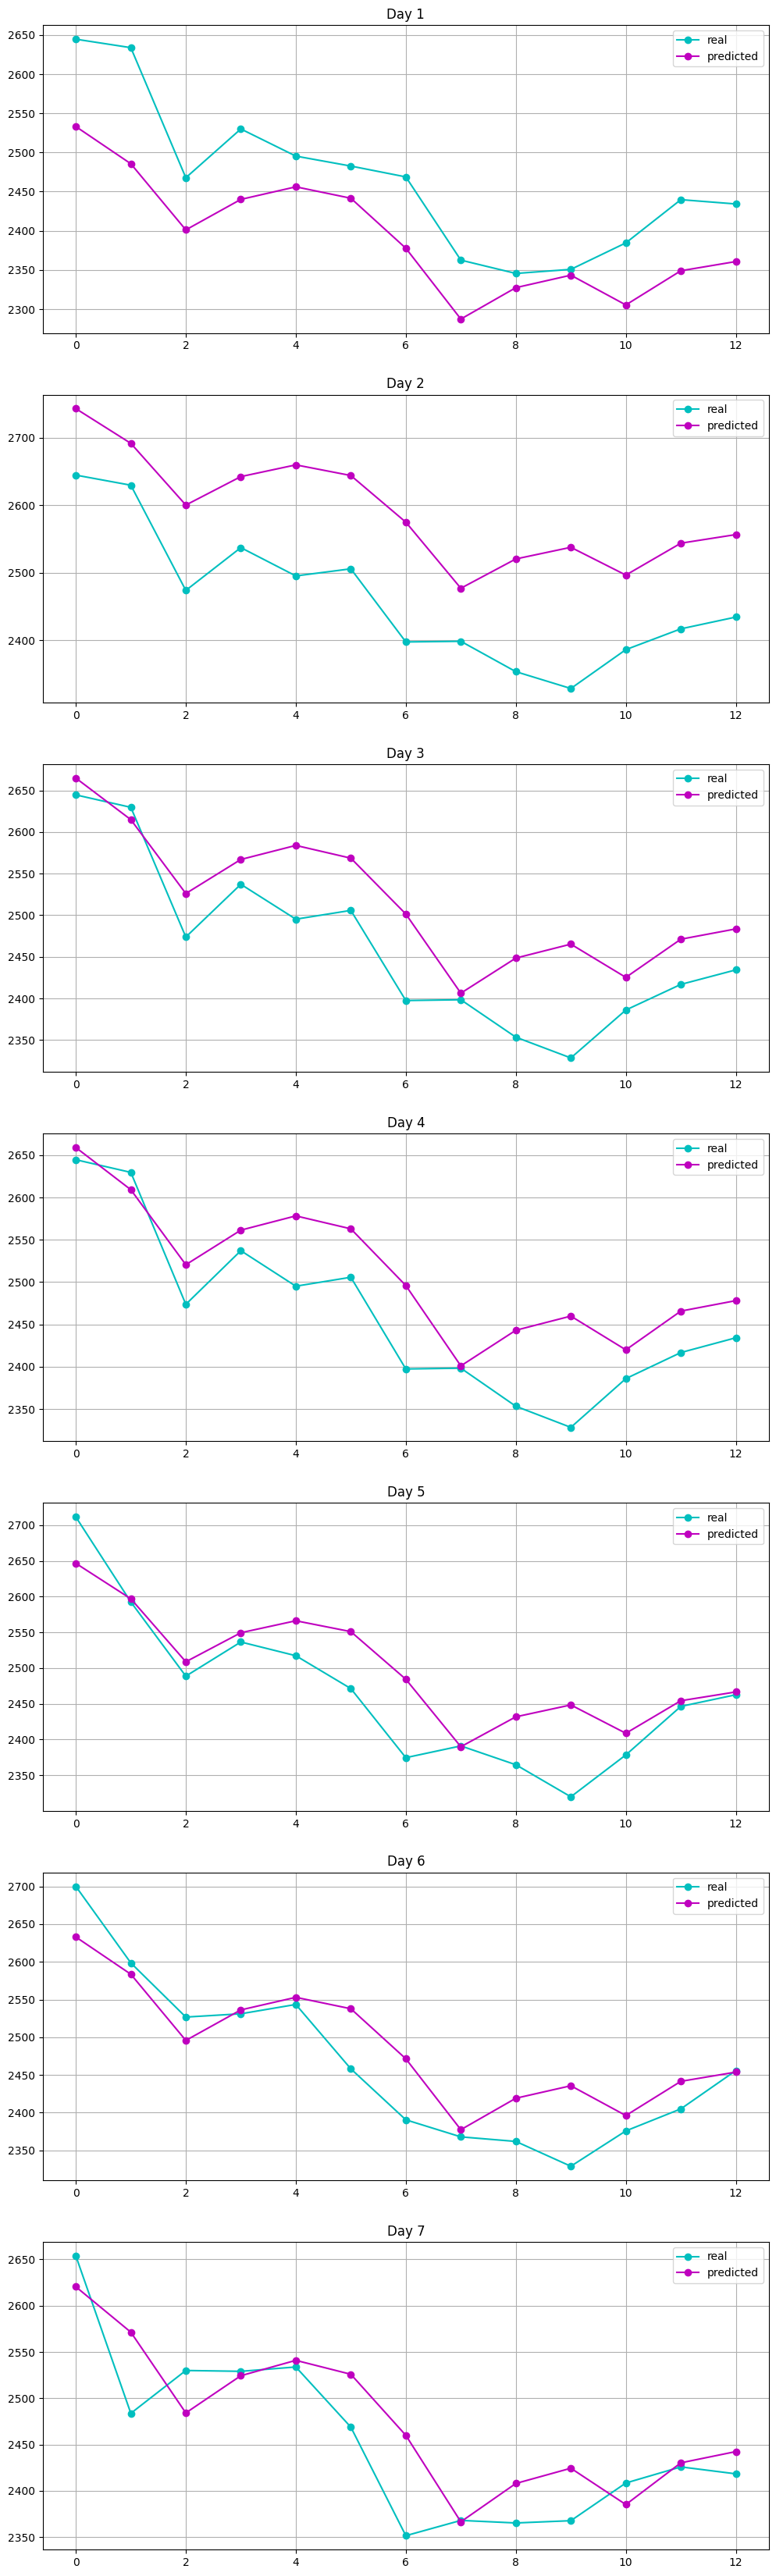

78.06355517540442 
 [80.57416771515773, 135.6966883839278, 68.83168077107662, 64.52566227427502, 60.551379083773654, 52.030982831191885, 49.765336650894284]


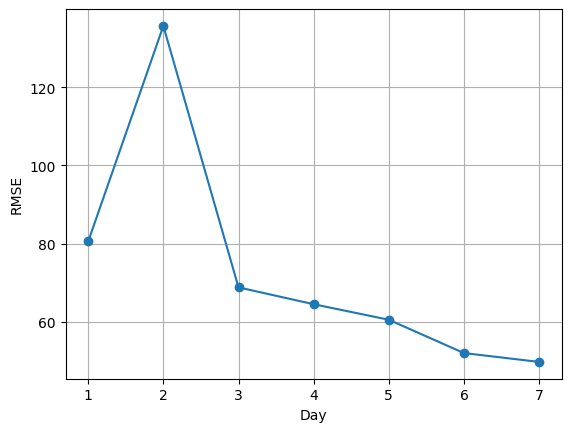

In [ ]:
n_input=7
model=delayed_model(tf.keras.layers.LSTM,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es],verbose=1)
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score[0],'\n',scores[0])
plot_error_days(scores)

#### **14 days**

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 8)              │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 7, 8)           │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 7, 8)           │            72 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 7, 2)           │            18 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 986 (3.85 KB)

 Trainable params: 986 (3.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 1959185536.0000
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71513384.0000
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72047656.0000
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72011448.0000
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71632320.0000
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71790848.0000
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 72111928.0000
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71648216.0000
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71875576.0000
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71492376.0000
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71850912.0000
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71449944.0000
Epoch 13/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71061960.0000
Epoch 14/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

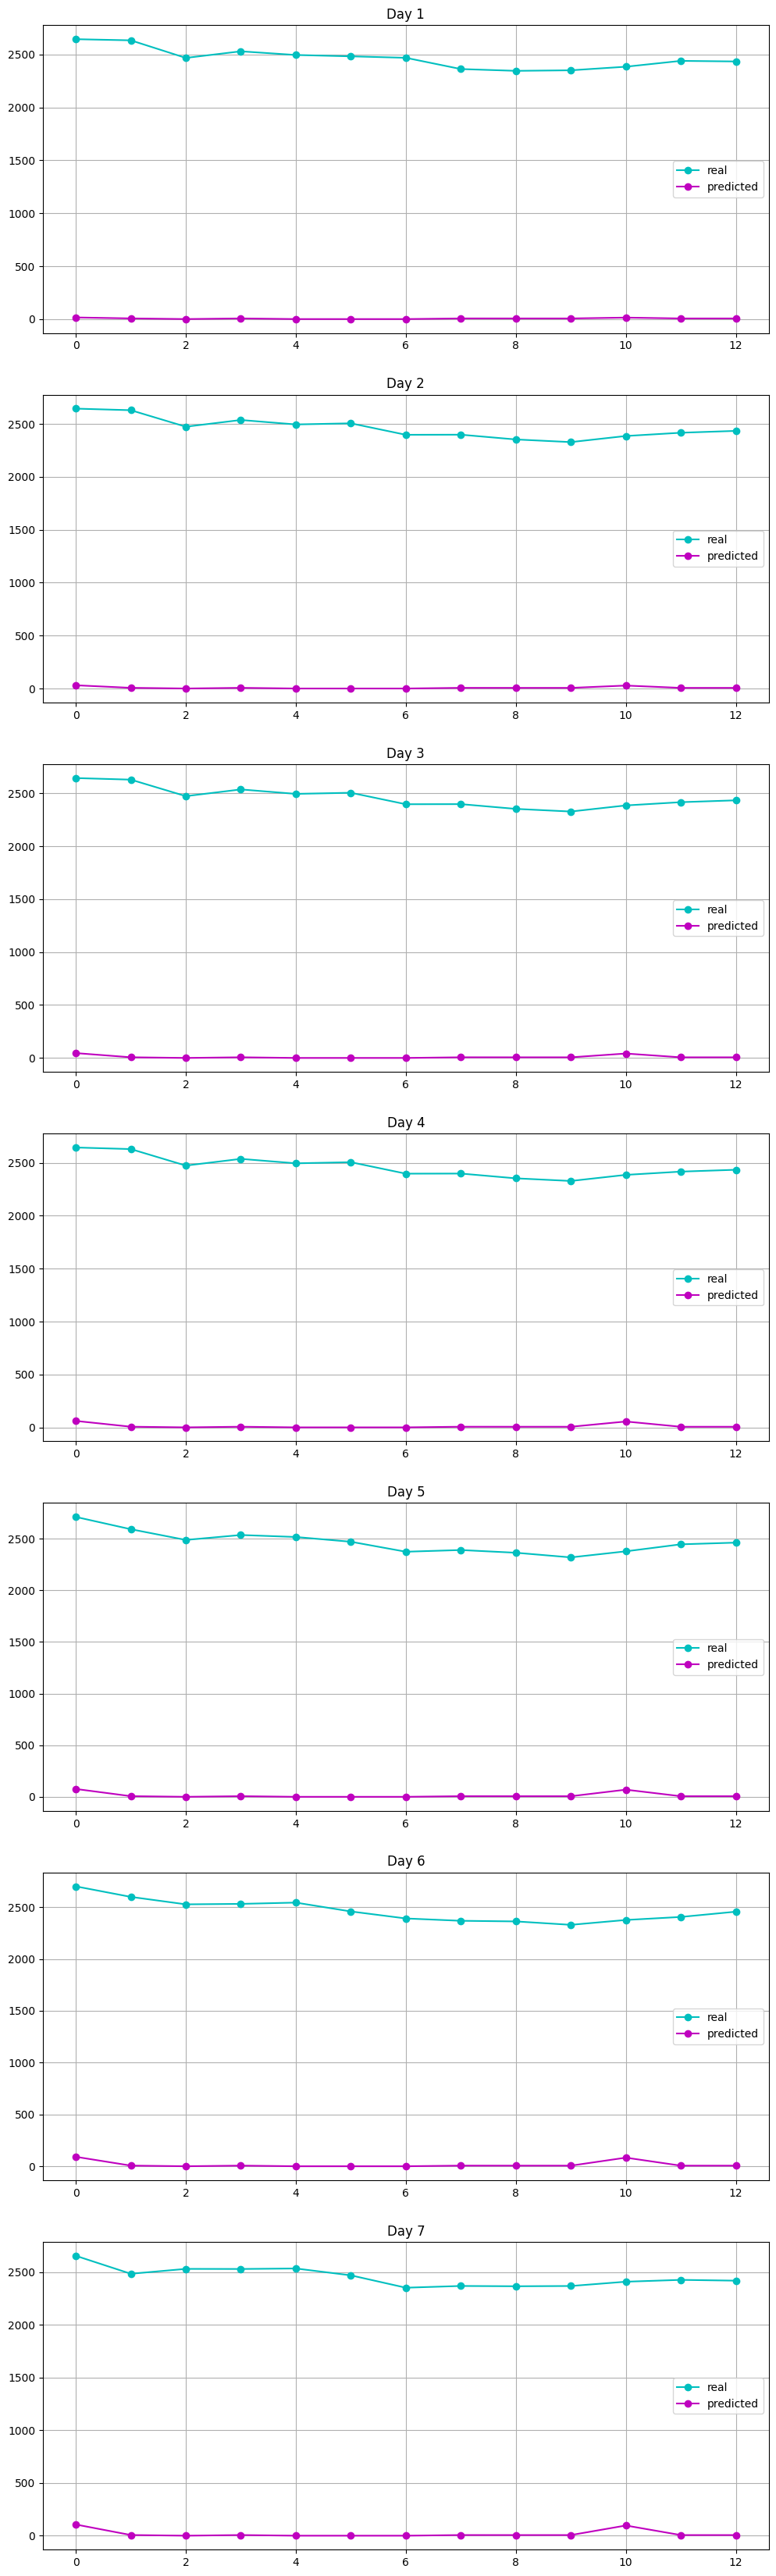

2451.62010213545 
 [2460.8811770466923, 2455.6115020455245, 2453.351621033007, 2451.1103588557207, 2453.35467243733, 2450.3387011380314, 2436.624466975056]


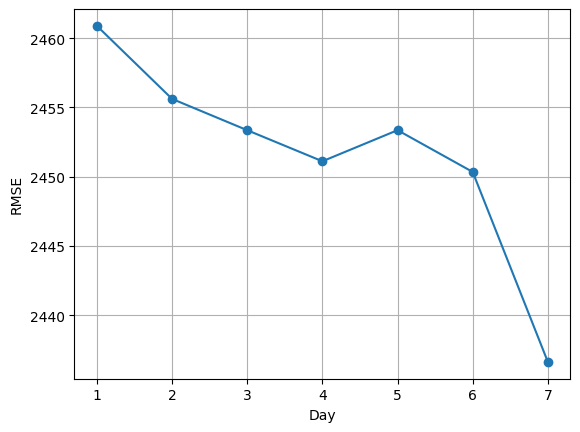

In [ ]:
n_input=14
model=delayed_model(tf.keras.layers.LSTM,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es],verbose=1)
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score[0],'\n',scores[0])
plot_error_days(scores)

### **GRU**

#### **7 days**

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_8 (GRU)                     │ (None, 8)              │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ (None, 7, 8)           │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 7, 8)           │            72 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 7, 2)           │            18 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 810 (3.16 KB)

 Trainable params: 810 (3.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 68816504.0000
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47913580.0000
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7991110.0000
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2400792.5000
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1450570.8750
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 812945.8125
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 438116.8125
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 217753.2188
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113953.7734
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66089.3672
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44337.0117
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34186.3672
Epoch 13/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37665.8516
Epoch 14/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31605.4629
Epoch 15/50
6

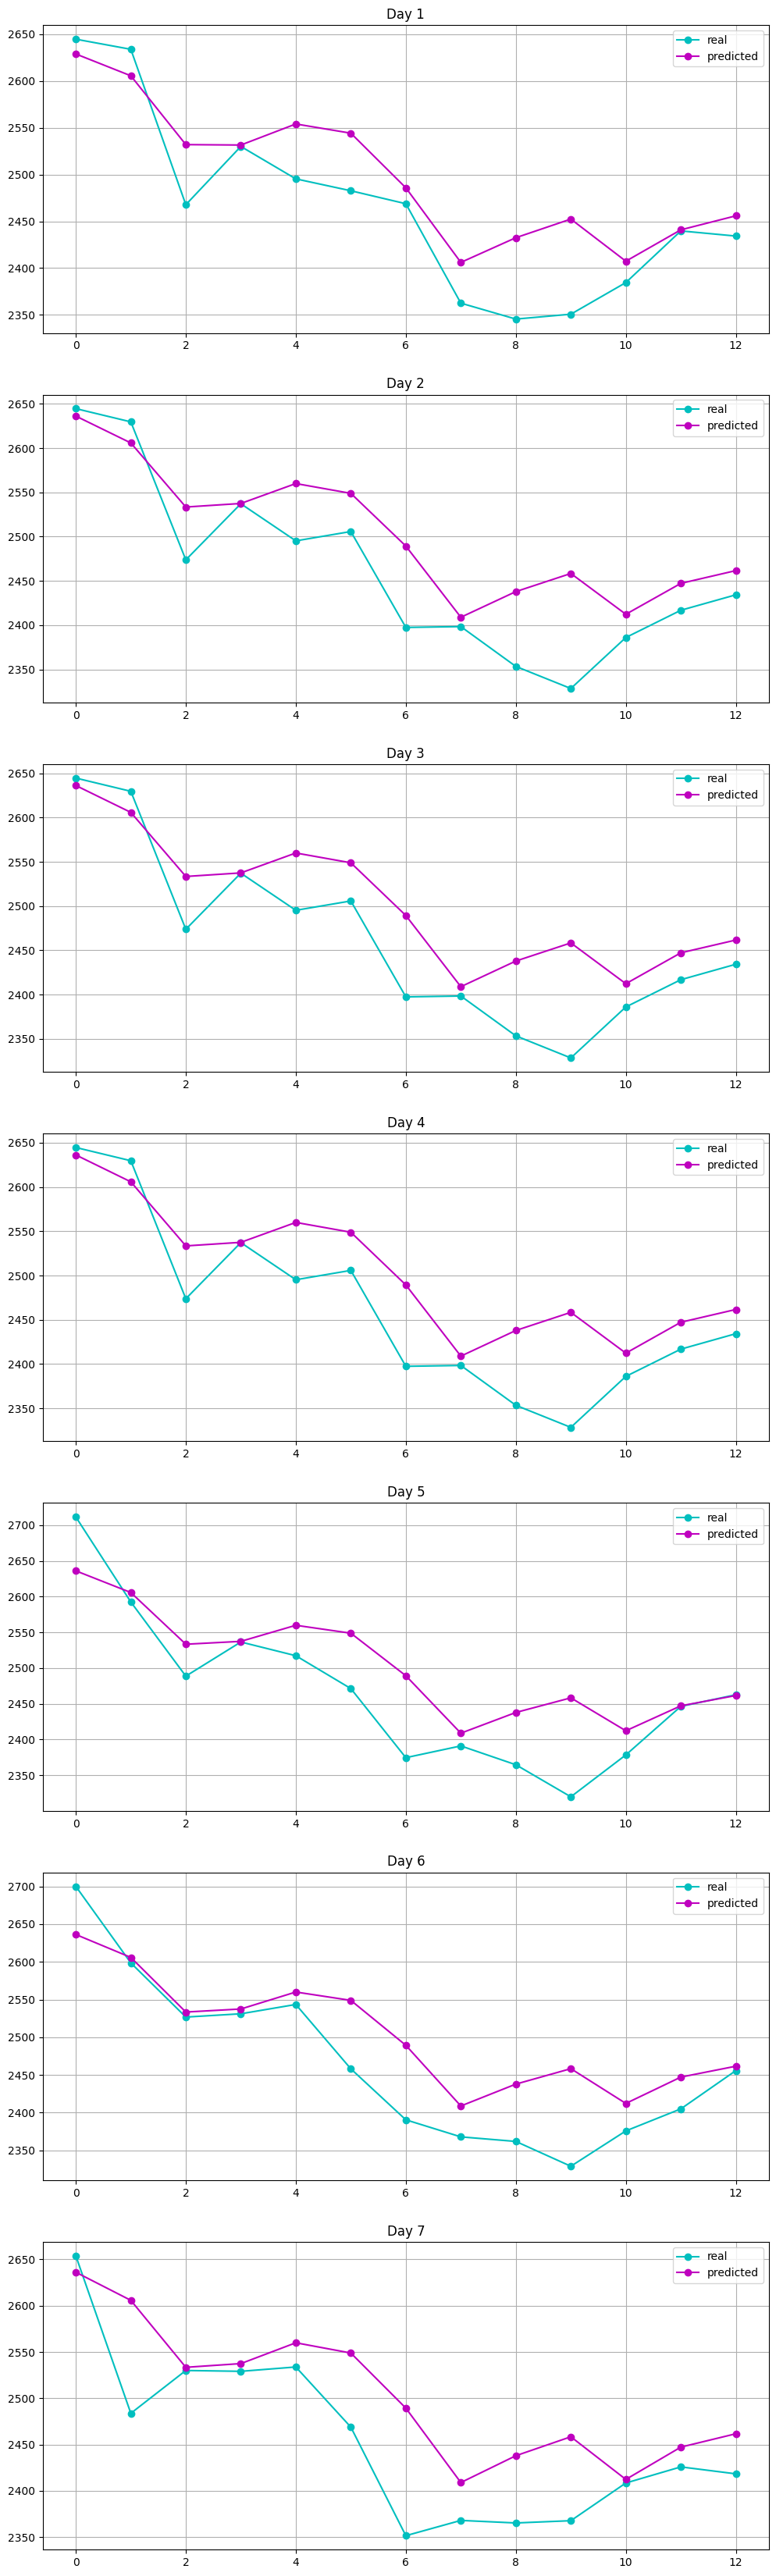

60.46625479087661 
 [50.735745600789684, 58.972349767459825, 58.972349767459825, 58.972349767459825, 64.96847455137856, 61.886023441865916, 67.34287789448301]


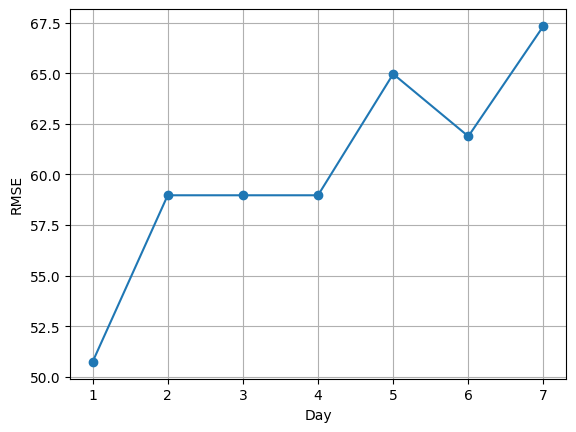

In [ ]:
n_input=7
model=delayed_model(tf.keras.layers.GRU,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es],verbose=1)
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score[0],'\n',scores[0])
plot_error_days(scores)

#### **14 days**

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, 8)              │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_7 (RepeatVector)  │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 7, 8)           │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 7, 8)           │            72 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 7, 2)           │            18 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 810 (3.16 KB)

 Trainable params: 810 (3.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 59529096.0000
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16728490.0000
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2226297.0000
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1395375.8750
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 810647.9375
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 424318.1562
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 215566.6406
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 111873.7422
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66465.6094
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50228.7773
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44326.2227
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40374.8398
Epoch 13/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44627.4492
Epoch 14/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43743.4102
Epoch 15/50
64

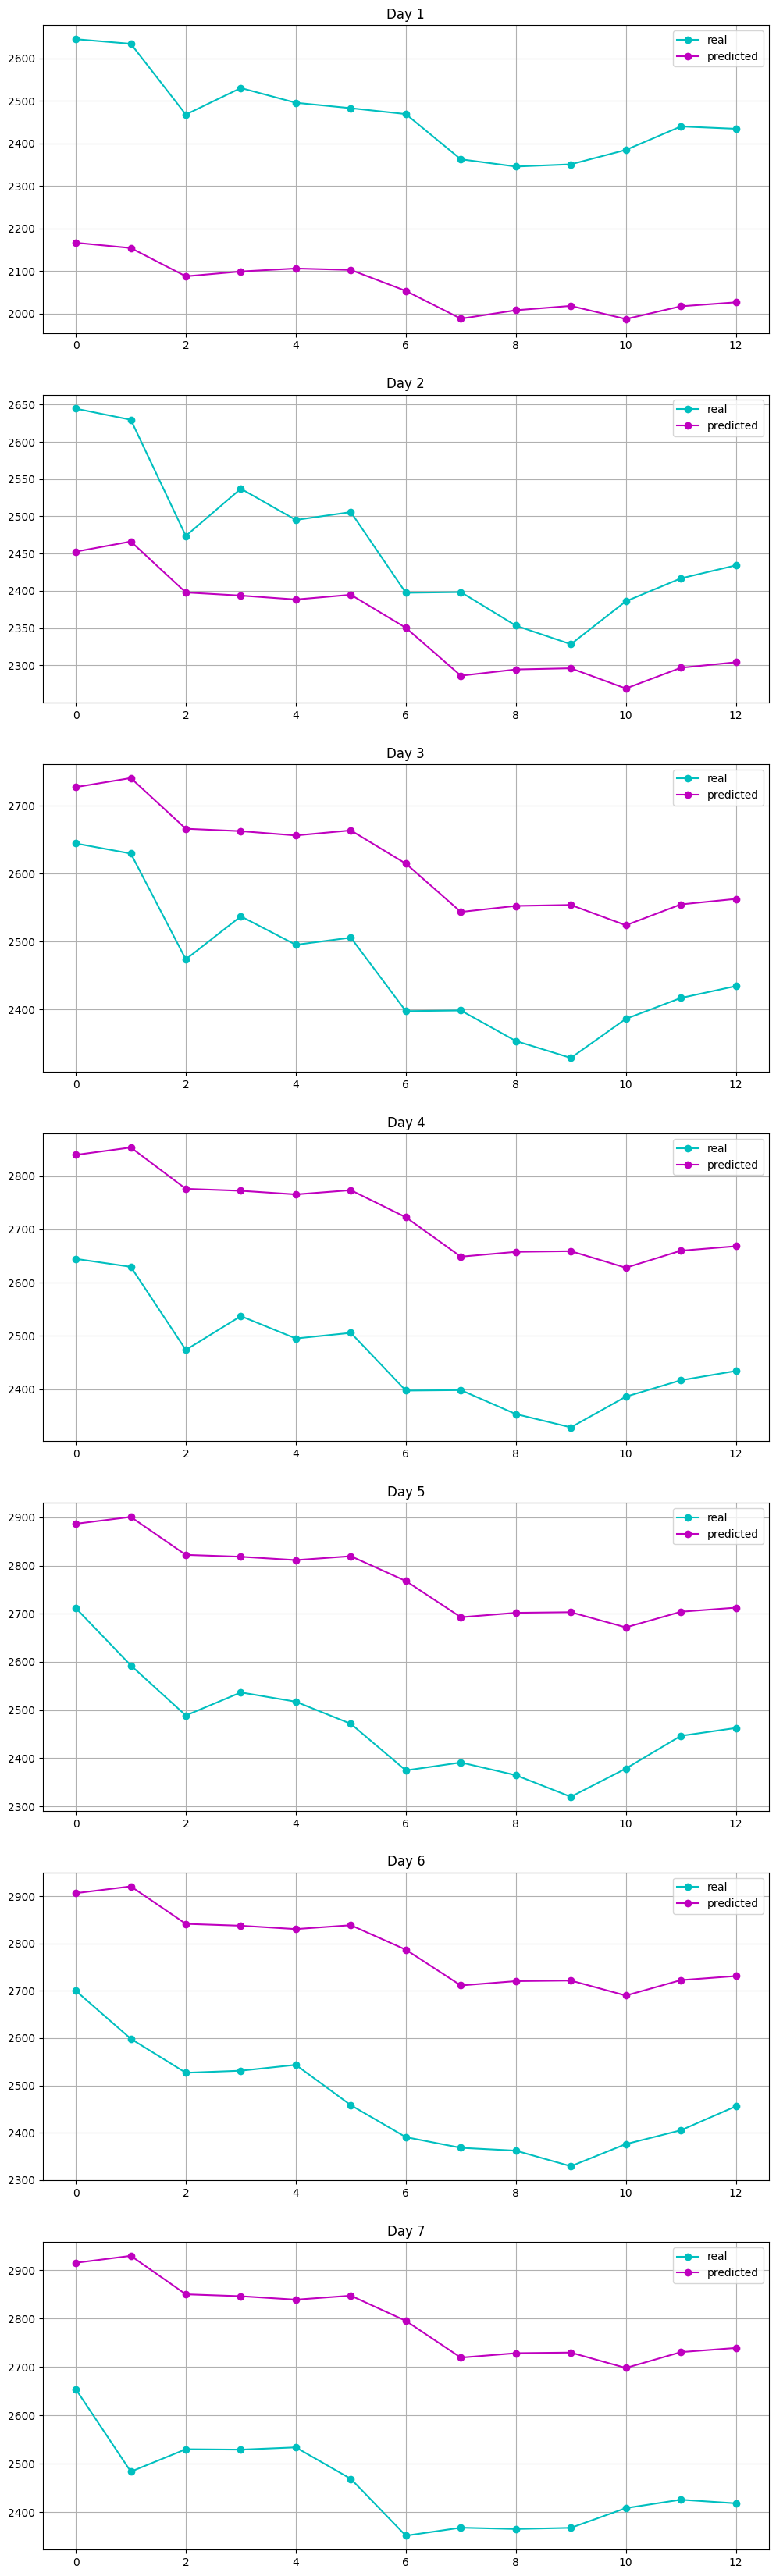

292.2562889678757 
 [404.0481344470346, 116.9846809986817, 160.88399461723353, 266.3796300346029, 309.45490108606816, 328.2302316492279, 347.29910848484053]


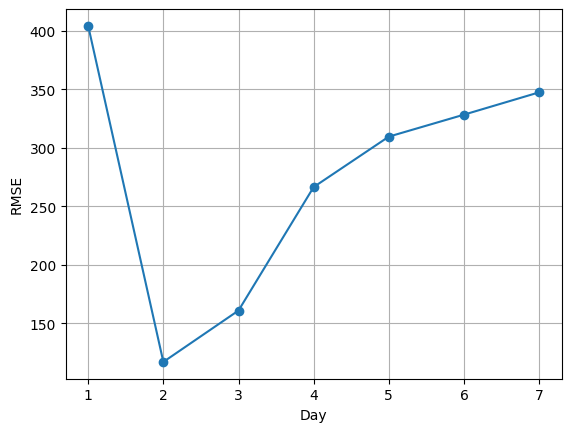

In [ ]:
n_input=14
model=delayed_model(tf.keras.layers.GRU,n_input)
model.summary()
X_train,y_train=create_dataset(data_train,n_input)
hist=model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=[es],verbose=1)
score,scores=evaluate_model(model,data_train,data_test,n_input)
print(score[0],'\n',scores[0])
plot_error_days(scores)